In [1]:
# Library importation
import pandas as pd
import numpy as np

# Figures
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import graphviz
from dtreeviz.trees import*

# Dataframe column views
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# ML
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn import dummy
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import svm
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import xgboost as xgb

# Metrics
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

import timeit
import time

import pprint


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Import of cleaning functions
from cleaning59 import na_rows_list, na_raw_drop_df, min_row_data_rate_list, min_row_data_rate_df, column_data_rate, column_data_rate_mean, columns_not_in_list, columns_delete_df, min_column_data_rate_df, low_outlier_filter_df, high_outlier_filter_df, dic_high_outlier_filter_df, word_column_filter_df, word_column_filter_lst, random_item

In [4]:
# Import of graph functions
from plotting03 import bi_joint_plot

# CHOICE OF THE PREDICTION YEAR

The last two years are predicted. For example, if the year 2020 is the latest available, thus:
> 2020: predicted

> 2019: predicted -> choice

> 2018: train

> 2017: train

> 2016: train

> other year available before: train

> (at least 3 years needed for a building to be in the training part)

In [5]:
# year is the first testing year, the fix set is builded with the previous three years (at least)
year = '2019'

In [6]:
# Previous years for training:
year_minus_1 = str(int(year) - 1)
year_minus_2 = str(int(year) - 2)
year_minus_3 = str(int(year) - 3)
year_minus_4 = str(int(year) - 4)

In [7]:
# Next year to be predicted:
year_plus_1 = str(int(year) + 1)

# DATA READING

In [8]:
# Data reading with path information
data = {}
for data_year in [year_minus_1,year_minus_2,year_minus_3,year_minus_4,year,year_plus_1]:

    data[str(data_year)] = pd.read_csv(f'projets\\04_seattle_building_energy\\production\\data_seattle_building_energy_modified_{data_year}.csv',sep=',')


In [9]:
## List of float variables from 2015 data
float_characteristics_lst_2015 = ['DataYear','YearBuilt','YearsENERGYSTARCertified',
                                  'OSEBuildingID','TaxParcelIdentificationNumber',
                                  'CouncilDistrictCode','NumberofBuildings',
                                  'NumberofFloors','PropertyGFATotal',
                                  'PropertyGFAParking','PropertyGFABuilding(s)',
                                  'LargestPropertyUseTypeGFA',
                                  'SecondLargestPropertyUseTypeGFA',
                                  'ThirdLargestPropertyUseTypeGFA',
                                  'ENERGYSTARScore']


float_measures_lst_2015 = ['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)',
                           'SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)',
                           'SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)',
                           'SteamUse(kBtu)','Electricity(kWh)','Electricity(kBtu)',
                           'NaturalGas(therms)','NaturalGas(kBtu)',
                           'OtherFuelUse(kBtu)','GHGEmissions(MetricTonsCO2e)',
                           'GHGEmissionsIntensity(kgCO2e/ft2)']

# modification of the list depending on the predicted year: 2015/2016/2017/2018/2019/2020

float_characteristics_lst = float_characteristics_lst_2015
float_measures_lst = float_measures_lst_2015


if int(year) == 2015:
     
    data.rename({'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity', 'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions'}, axis=1, inplace=True)
    
    float_measures_lst.remove('GHGEmissionsIntensity(kgCO2e/ft2)')
    float_measures_lst.remove('GHGEmissions(MetricTonsCO2e)')
    
    float_measures_lst.append('GHGEmissionsIntensity')
    float_measures_lst.append('TotalGHGEmissions')
    
    float_measures_lst.remove('OtherFuelUse(kBtu)')
    
    
if (int(year) == 2016) | (int(year) == 2017) | (int(year) == 2018) | (int(year) == 2019) | (int(year) == 2020):

    float_measures_lst.remove('GHGEmissionsIntensity(kgCO2e/ft2)')
    float_measures_lst.remove('GHGEmissions(MetricTonsCO2e)')
    
    float_measures_lst.append('GHGEmissionsIntensity')
    float_measures_lst.append('TotalGHGEmissions')
    
    float_measures_lst.remove('OtherFuelUse(kBtu)')
       
    
if (int(year) == 2018) | (int(year) == 2019) | (int(year) == 2020):

    float_characteristics_lst.remove('YearsENERGYSTARCertified')

if (int(year) == 2019) | (int(year) == 2020):
    float_characteristics_lst.remove('NumberofBuildings')

if (int(year) == 2020):
    float_measures_lst.remove('NaturalGas(therms)')
    
    data.rename({'EPAPropertyType': 'PrimaryPropertyType'}, axis=1, inplace=True)

    
float_lst = float_characteristics_lst + float_measures_lst


In [10]:
data[year_minus_1].shape

(3537, 70)

In [11]:
data[year_minus_2].shape

(3191, 73)

In [12]:
data[year_minus_3].shape

(3211, 74)

In [13]:
data[year_minus_4].shape

(3253, 70)

In [14]:
data[year].shape

(3268, 70)

In [15]:
data[year_plus_1].shape

(3447, 71)

# "FIX SET" CREATION

The input condition in the fix set is to have reliable data for three consecutive years for a building 

In [16]:
# List of unique buildings in "year"
list_0 = list(data[year]['OSEBuildingID'].unique())
len(list_0)

3268

In [17]:
# Reminder on the number of rows
data[year].shape

(3268, 70)

In [18]:
# List of buildings in the fix dataset (at least three years before the predicted 'year')

# List of buildings to be in the fix set
fix_lst_base = []

# List of buildings each year before the predicted 'year'
list_minus_1 = list(data[year_minus_1]['OSEBuildingID'].unique())
list_minus_2 = list(data[year_minus_2]['OSEBuildingID'].unique())
list_minus_3 = list(data[year_minus_3]['OSEBuildingID'].unique())
list_minus_4 = list(data[year_minus_4]['OSEBuildingID'].unique())

# buildings in common each year before the predicted 'year'
for building in list_0:
    if (
        (building in list_minus_1) and 
        (building in list_minus_2) and
        (building in list_minus_3) and
        (building in list_minus_4)):
        fix_lst_base.append(building)
len(fix_lst_base)

2588

In [19]:
# Filter on the dataset of year with the fix set list:

data_year_fix_set = data[year][data[year]['OSEBuildingID'].isin(fix_lst_base)]
data_year_fix_set.shape

(2588, 70)

In [20]:
# Filter on the dataset of year-1 with the fix set list:

data_year_minus_1_fix_set = data[year_minus_1][data[year_minus_1]['OSEBuildingID'].isin(fix_lst_base)]
data_year_minus_1_fix_set.shape

(2588, 70)

In [21]:
# Filtre fix set sur l'année -2:

data_year_minus_2_fix_set = data[year_minus_2][data[year_minus_2]['OSEBuildingID'].isin(fix_lst_base)]
data_year_minus_2_fix_set.shape

(2588, 73)

In [22]:
# Filter on the dataset of year-2 with the fix set list:

data_year_minus_2_fix_set = data[year_minus_2][data[year_minus_2]['OSEBuildingID'].isin(fix_lst_base)]
data_year_minus_2_fix_set.shape

(2588, 73)

In [23]:
# Filter on the dataset of year-3 with the fix set list:

data_year_minus_3_fix_set = data[year_minus_3][data[year_minus_3]['OSEBuildingID'].isin(fix_lst_base)]
data_year_minus_3_fix_set.shape

(2588, 74)

In [24]:
# Filter on the dataset of year-4 with the fix set list:

data_year_minus_4_fix_set = data[year_minus_4][data[year_minus_4]['OSEBuildingID'].isin(fix_lst_base)]
data_year_minus_4_fix_set.shape

(2588, 70)

In [25]:
# Filter on the dataset of year+1 with the fix set list:
data_year_plus_1_fix_set = data[year_plus_1][data[year_plus_1]['OSEBuildingID'].isin(fix_lst_base)]
data_year_plus_1_fix_set.shape

(2518, 71)

In [26]:
# Creation of a dictionnary of fix set dataframes per year

data_fix_set = {}
for data_year in [year_minus_4, year_minus_3, year_minus_2, year_minus_1, year, year_plus_1]:

    if data_year == year_minus_4:
        data_fix_set[str(data_year)] = data_year_minus_4_fix_set.copy()
    
    if data_year == year_minus_3:
        data_fix_set[str(data_year)] = data_year_minus_3_fix_set.copy()
    
    if data_year == year_minus_2:
        data_fix_set[str(data_year)] = data_year_minus_2_fix_set.copy()
        
    if data_year == year_minus_1:
        data_fix_set[str(data_year)] = data_year_minus_1_fix_set.copy()
        
    if data_year == year:
        data_fix_set[str(data_year)] = data_year_fix_set.copy()
        
    if data_year == year_plus_1:
        data_fix_set[str(data_year)] = data_year_plus_1_fix_set.copy()
        
    

In [27]:
data_fix_set[year_plus_1].shape

(2518, 71)

In [28]:
data_fix_set[year].shape

(2588, 70)

In [29]:
data_fix_set[year_minus_1].shape

(2588, 70)

In [30]:
data_fix_set[year_minus_2].shape

(2588, 73)

In [31]:
data_fix_set[year_minus_3].shape

(2588, 74)

In [32]:
data_fix_set[year_minus_4].shape

(2588, 70)

# DATASET CREATION FOR TRAINING/VALIDATION

## Concatenation of modified "fix set" dataset year_minus_1/year_minus_2/year_minus_3/year_minus_4 

In [33]:
# Concatenation
data_fix_set_train_val = pd.concat([data_fix_set[year_minus_1], data_fix_set[year_minus_2], data_fix_set[year_minus_3], data_fix_set[year_minus_4]])
data_fix_set_train_val.shape

(10352, 79)

In [34]:
# Duplicated values check
data_fix_set_train_val.duplicated().value_counts()

False    10352
dtype: int64

In [35]:
# We obtain the train/validation dataset
data_fix_set_train_val

,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,Longitude,Neighborhood,CouncilDistrictCode,YearBuilt,NumberofFloors,NumberofBuildings,PropertyGFATotal,PrimaryPropertyType,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,TotalGHGEmissions,ComplianceStatus,ComplianceIssue,elec_gas_steam_otherfuel_prop,energy_type_01,energy_type_02,energy_type_03,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,SiteEnergyUse(kBtu)_cat,SiteEnergyUse(kBtu)_cat_LabelEncoded,SiteEnergyUseWN(kBtu)_cat,SiteEnergyUseWN(kBtu)_cat_LabelEncoded,PrimaryPropertyType_new_cat,PrimaryPropertyType_new_cat_TargetEncoded,LargestPropertyUseType_new_cat,LargestPropertyUseType_new_cat_TargetEncoded,SecondLargestPropertyUseType_new_cat,SecondLargestPropertyUseType_new_cat_TargetEncoded,ThirdLargestPropertyUseType_new_cat,ThirdLargestPropertyUseType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded,PrimaryPropertyType_new_cat_<Class Missing>,PrimaryPropertyType_new_cat_<Commercial centers>,PrimaryPropertyType_new_cat_<Education>,PrimaryPropertyType_new_cat_<Health services>,PrimaryPropertyType_new_cat_<Hotel/Restaurant>,PrimaryPropertyType_new_cat_<Industry>,PrimaryPropertyType_new_cat_<Logistic/Distribution centers>,PrimaryPropertyType_new_cat_<Mixed Use Property>,PrimaryPropertyType_new_cat_<Multifamily Housing>,PrimaryPropertyType_new_cat_<Office>,PrimaryPropertyType_new_cat_<Other/Public places>,CouncilDistrictCode_<1>,CouncilDistrictCode_<2>,CouncilDistrictCode_<3>,CouncilDistrictCode_<4>,CouncilDistrictCode_<5>,CouncilDistrictCode_<6>,CouncilDistrictCode_<7>,energy_type_02_<Class Missing>,energy_type_02_<electricity>,energy_type_02_<gas>,energy_type_02_<steam>,PropertyName,ListOfAllPropertyUseTypes,YearsENERGYSTARCertified,DefaultData,Outlier,Comments,Location,OtherFuelUse(kBtu),Comment
0,1,2018,MAYFLOWER PARK HOTEL,NonResidential,6.590000e+08,405 OLIVE WAY,SEATTLE,WA,98101.0,47.61220,-122.33799,DOWNTOWN,1.0,1927.0,12.0,NaN,88434,Hotel,60.0,6.873087,6.869718,Hotel,NaN,NaN,NaN,2.293141,Compliant,No Issue,"[0.5275106033255452, 0.19034692086121371, 0.28...",electricity,steam,gas,7.156389,7.140463,6.322154,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.731689,Hotel/Restaurant,6.747441,Hotel/Restaurant,6.747441,Class Missing,6.281809,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2018,PARAMOUNT HOTEL,NonResidential,6.590002e+08,724 PINE ST,SEATTLE,WA,98101.0,47.61317,-122.33393,DOWNTOWN,1.0,1996.0,11.0,1.0,103566,Hotel,71.0,6.901075,6.897481,Hotel,Parking,Restaurant,4622.0,2.439017,Compliant,No Issue,"[0.36298464863824487, 0.6370153513617551, nan]",gas,electricity,Class Missing,6.331686,6.441952,6.409418,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.731689,Hotel/Restaurant,6.747441,Hotel/Restaurant,6.747441,Hotel/Restaurant,6.667520,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2018,WESTIN HOTEL (Parent Building),NonResidential,6.590005e+08,1900 5TH AVE,SEATTLE,WA,98101.0,47.61393,-122.33810,DOWNTOWN,1.0,1969.0,41.0,3.0,956110,Hotel,64.0,7.828250,7.824487,Hotel,Parking,Swimming Pool,NaN,3.115344,Compliant,No Issue,"[0.6659169412268634, 0.021725534756668694, 0.3...",electricity,steam,gas,7.156389,7.140463,6.322154,Highest Use,0,Highest Use,0,Hotel/Restaurant,6.731689,Hotel/Restaurant,6.747441,Hotel/Restaurant,6.747441,Other/Public places,6.684807,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,2018,WARWICK SEATTLE HOTEL,NonResidential,6.590010e+08,401 LENORA ST,SEATTLE,WA,98121.0,47.61375,-122.34047,DOWNTOWN,1.0,1980.0,18.0,NaN,175580,Hotel,81.0,7.122606,7.118400,Hotel,Parking,Swimming Pool

## Random raw of buildings on several years

In [36]:
# Reset of the index
data_fix_set_train_val.reset_index(drop=True, inplace=True)
data_fix_set_train_val.shape

(10352, 79)

In [37]:
# One building appears in consecutive years, we do a random draw to avoid overfitting
data_fix_set_train_val_random = random_item(data_fix_set_train_val, 'OSEBuildingID')
data_fix_set_train_val_random

,OSEBuildingID,DataYear,BuildingName,BuildingType,TaxParcelIdentificationNumber,Address,City,State,ZipCode,Latitude,Longitude,Neighborhood,CouncilDistrictCode,YearBuilt,NumberofFloors,NumberofBuildings,PropertyGFATotal,PrimaryPropertyType,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,TotalGHGEmissions,ComplianceStatus,ComplianceIssue,elec_gas_steam_otherfuel_prop,energy_type_01,energy_type_02,energy_type_03,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,SiteEnergyUse(kBtu)_cat,SiteEnergyUse(kBtu)_cat_LabelEncoded,SiteEnergyUseWN(kBtu)_cat,SiteEnergyUseWN(kBtu)_cat_LabelEncoded,PrimaryPropertyType_new_cat,PrimaryPropertyType_new_cat_TargetEncoded,LargestPropertyUseType_new_cat,LargestPropertyUseType_new_cat_TargetEncoded,SecondLargestPropertyUseType_new_cat,SecondLargestPropertyUseType_new_cat_TargetEncoded,ThirdLargestPropertyUseType_new_cat,ThirdLargestPropertyUseType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded,PrimaryPropertyType_new_cat_<Class Missing>,PrimaryPropertyType_new_cat_<Commercial centers>,PrimaryPropertyType_new_cat_<Education>,PrimaryPropertyType_new_cat_<Health services>,PrimaryPropertyType_new_cat_<Hotel/Restaurant>,PrimaryPropertyType_new_cat_<Industry>,PrimaryPropertyType_new_cat_<Logistic/Distribution centers>,PrimaryPropertyType_new_cat_<Mixed Use Property>,PrimaryPropertyType_new_cat_<Multifamily Housing>,PrimaryPropertyType_new_cat_<Office>,PrimaryPropertyType_new_cat_<Other/Public places>,CouncilDistrictCode_<1>,CouncilDistrictCode_<2>,CouncilDistrictCode_<3>,CouncilDistrictCode_<4>,CouncilDistrictCode_<5>,CouncilDistrictCode_<6>,CouncilDistrictCode_<7>,energy_type_02_<Class Missing>,energy_type_02_<electricity>,energy_type_02_<gas>,energy_type_02_<steam>,PropertyName,ListOfAllPropertyUseTypes,YearsENERGYSTARCertified,DefaultData,Outlier,Comments,Location,OtherFuelUse(kBtu),Comment
2588,1,2017,NaN,NonResidential,6.590000e+08,405 Olive way,Seattle,WA,98101.0,47.61220,-122.33799,DOWNTOWN,7.0,1927.0,12.0,1.0,88434,Hotel,63.0,6.866975,6.861800,Hotel,NaN,NaN,NaN,2.295853,Compliant,NaN,"[0.5366125076420276, 0.17502355537825318, 0.28...",electricity,steam,gas,7.091162,7.073360,6.331790,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.859677,Hotel/Restaurant,6.712027,Hotel/Restaurant,6.712027,Class Missing,6.303633,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,Mayflower park hotel,Hotel,NaN,N,NaN,NaN,NaN,NaN,NaN
5177,2,2016,NaN,NonResidential,6.590002e+08,724 Pine street,Seattle,WA,98101.0,47.61317,-122.33393,DOWNTOWN,7.0,1996.0,11.0,1.0,103566,Hotel,61.0,6.923655,6.937742,Hotel,Parking,Restaurant,4622.0,2.471086,Compliant,NaN,"[0.38660907281925116, 0.6133909271807488, nan]",gas,electricity,Class Missing,6.345059,6.449379,6.435758,Medium-High,2,Medium-High,2,Hotel/Restaurant,6.886444,Hotel/Restaurant,6.738145,Hotel/Restaurant,6.738145,Hotel/Restaurant,6.658278,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,Paramount Hotel,"Hotel, Parking, Restaurant",NaN,False,NaN,NaN,NaN,NaN,NaN
5178,3,2016,NaN,NonResidential,6.590005e+08,1900 5th Avenue,Seattle,WA,98101.0,47.61393,-122.33810,DOWNTOWN,7.0,1969.0,41.0,1.0,956110,Hotel,43.0,7.860859,7.868862,Hotel,NaN,NaN,NaN,3.319997,Compliant,NaN,"[0.6823074616455521, 0.020579437496660906, 0.2...",electricity,steam,gas,7.059833,7.006973,6.337084,Highest Use,0,Highest Use,0,Hotel/Restaurant,6.886444,Hotel/Restaurant,6.738145,Hotel/Restaurant,6.738145,Class Missing,6.304286,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5673-The Westin Seattle,Hotel,NaN,False,NaN,NaN,NaN,NaN,NaN
2591,8,2017,NaN,NonResidential,6.590010e+08,401 LENORA ST,Seattle,WA,98121.0,47.61375,-122.34047,DOWNTOWN,7.0,1980.0,18.0,1.0,175580,Hotel,78.0,7.156421,7.148641,Hotel,Parking,Swimming Pool,NaN,2.704

In [38]:
# Filling rate by column
column_data_rate(data_fix_set_train_val_random)

OSEBuildingID                                                  1.000000
DataYear                                                       1.000000
BuildingName                                                   0.252318
BuildingType                                                   1.000000
TaxParcelIdentificationNumber                                  0.998841
Address                                                        0.729521
City                                                           0.729521
State                                                          0.729521
ZipCode                                                        0.728748
Latitude                                                       0.726430
Longitude                                                      0.726430
Neighborhood                                                   0.996909
CouncilDistrictCode                                            1.000000
YearBuilt                                                      1

In [39]:
# Copy of the fix set for later
data_fix_set_train_val_random_freezed = data_fix_set_train_val_random.copy()

In [40]:
# List of duplicated variables or to be deleted:
lst_delete = ['Address','City','State','PropertyName','ZipCode', 'Latitude',
             'Longitude','ListOfAllPropertyUseTypes', 
             'YearsENERGYSTARCertified','DefaultData']

lst_delete_02 = ['PrimaryPropertyType','DataYear','BuildingType', 'Neighborhood', 'LargestPropertyUseType','SecondLargestPropertyUseType','CouncilDistrictCode',
'ThirdLargestPropertyUseType','ComplianceStatus','Outlier',
'elec_gas_steam_otherfuel_prop','energy_type_01','energy_type_02','energy_type_03',
'SiteEnergyUse(kBtu)_cat', 'SiteEnergyUseWN(kBtu)_cat', 'PrimaryPropertyType_new_cat','LargestPropertyUseType_new_cat',
'SecondLargestPropertyUseType_new_cat', 'ThirdLargestPropertyUseType_new_cat',
'Comments', 'Location', 'Comment']

lst_delete_03 = ['OSEBuildingID','TaxParcelIdentificationNumber','ThirdLargestPropertyUseTypeGFA']

data_fix_set_train_val_random.drop(lst_delete,axis=1, inplace=True)
data_fix_set_train_val_random.drop(lst_delete_02,axis=1, inplace=True)
data_fix_set_train_val_random.drop(lst_delete_03,axis=1, inplace=True)


In [41]:
# List of encoded variables to be deleted depending on the algorithm:
lst_delete_04 = ['energy_type_02_<electricity>', 'energy_type_02_<gas>',
                 'energy_type_02_<steam>', 'energy_type_02_<Class Missing>']
data_fix_set_train_val_random.drop(lst_delete_04,axis=1, inplace=True)

In [42]:
# List of encoded variables to be deleted depending on the algorithm:
lst_delete_05 = ['CouncilDistrictCode_<1>', 'CouncilDistrictCode_<2>',
                 'CouncilDistrictCode_<3>', 'CouncilDistrictCode_<4>',
                 'CouncilDistrictCode_<5>', 'CouncilDistrictCode_<6>',
                 'CouncilDistrictCode_<7>']
data_fix_set_train_val_random.drop(lst_delete_05,axis=1, inplace=True)

In [43]:
# List of encoded variables to be deleted depending on the algorithm:
lst_delete_05_bis = ['PrimaryPropertyType_new_cat_<Class Missing>',
                 'PrimaryPropertyType_new_cat_<Commercial centers>',
                 'PrimaryPropertyType_new_cat_<Education>',
                 'PrimaryPropertyType_new_cat_<Health services>',
                 'PrimaryPropertyType_new_cat_<Hotel/Restaurant>',
                 'PrimaryPropertyType_new_cat_<Industry>',
                 'PrimaryPropertyType_new_cat_<Logistic/Distribution centers>',
                 'PrimaryPropertyType_new_cat_<Mixed Use Property>',
                 'PrimaryPropertyType_new_cat_<Multifamily Housing>',
                 'PrimaryPropertyType_new_cat_<Office>',
                 'PrimaryPropertyType_new_cat_<Other/Public places>',
                 ]
data_fix_set_train_val_random.drop(lst_delete_05_bis,axis=1, inplace=True)

In [44]:
# Variable deleting after RFECV - itération 1:
lst_delete_06 = ['LargestPropertyUseType_new_cat_TargetEncoded',
                 'SecondLargestPropertyUseType_new_cat_TargetEncoded', 'ThirdLargestPropertyUseType_new_cat_TargetEncoded']
data_fix_set_train_val_random.drop(lst_delete_06,axis=1, inplace=True)

In [45]:
# Choice of variable deleting:'ENERGYSTARScore' (high imputation)
ENERGYSTARScore_choice = input("Do you want to include 'ENERGYSTARScore' the the features? (yes/no)")
if ENERGYSTARScore_choice == 'no':
    lst_delete_07 = ['ENERGYSTARScore']
    data_fix_set_train_val_random.drop(lst_delete_07,axis=1, inplace=True)

Do you want to include 'ENERGYSTARScore' the the features? (yes/no) yes


In [46]:
# Filling rate by column
column_data_rate(data_fix_set_train_val_random)

BuildingName                                 0.252318
YearBuilt                                    1.000000
NumberofFloors                               1.000000
NumberofBuildings                            0.763910
PropertyGFATotal                             1.000000
ENERGYSTARScore                              1.000000
SiteEnergyUse(kBtu)                          1.000000
SiteEnergyUseWN(kBtu)                        1.000000
TotalGHGEmissions                            1.000000
ComplianceIssue                              0.252318
energy_type_03_TargetEncoded                 1.000000
energy_type_02_TargetEncoded                 1.000000
energy_type_01_TargetEncoded                 1.000000
SiteEnergyUse(kBtu)_cat_LabelEncoded         1.000000
SiteEnergyUseWN(kBtu)_cat_LabelEncoded       1.000000
PrimaryPropertyType_new_cat_TargetEncoded    1.000000
CouncilDistrictCode_TargetEncoded            1.000000
OtherFuelUse(kBtu)                           0.270093
dtype: float64

## Split train/validation for feature selection

In [47]:
# Copy of dataframe
data_fix_set_train_val_random_X = data_fix_set_train_val_random.copy()
data_fix_set_train_val_random_X


,BuildingName,YearBuilt,NumberofFloors,NumberofBuildings,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions,ComplianceIssue,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,SiteEnergyUse(kBtu)_cat_LabelEncoded,SiteEnergyUseWN(kBtu)_cat_LabelEncoded,PrimaryPropertyType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded,OtherFuelUse(kBtu)
2588,NaN,1927.0,12.0,1.0,88434,63.0,6.866975,6.861800,2.295853,NaN,7.091162,7.073360,6.331790,2,2,6.859677,7.0,NaN
5177,NaN,1996.0,11.0,1.0,103566,61.0,6.923655,6.937742,2.471086,NaN,6.345059,6.449379,6.435758,2,2,6.886444,7.0,NaN
5178,NaN,1969.0,41.0,1.0,956110,43.0,7.860859,7.868862,3.319997,NaN,7.059833,7.006973,6.337084,0,0,6.886444,7.0,NaN
2591,NaN,1980.0,18.0,1.0,175580,78.0,7.156421,7.148641,2.704837,NaN,6.342457,6.448662,6.421342,2,2,6.859677,7.0,NaN
2592,NaN,1926.0,11.0,1.0,83008,33.0,6.770932,6.760674,2.243608,NaN,6.342457,6.448662,6.421342,2,2,6.859677,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10350,NaN,2014.0,6.0,1.0,81993,85.0,6.407998,6.436425,1.833083,NaN,6.339617,6.486824,6.331825,3,3,6.225568,7.0,0.0
7760,NaN,2014.0,2.0,1.0,25532,74.0,5.797859,5.826263,0.641474,NaN,6.345059,6.119935,6.337084,3,3,6.232995,7.0,NaN
7761,NaN,2000.0,4.0,1.0,44650,58.0,6.096423,6.115786,0.939519,NaN,6.345059,6.119935,6.337084,3,3,6.232995,2.0,NaN
2586,IDENTITY APTS 4123,2014.0,7.0,1.0,42393,99.0,6.173122,6.162417,1.408240,No Issue,6.331686,6.477286,6.322154,3,3,6.195792,4.0,NaN


In [48]:
# Target deleting
data_fix_set_train_val_random_X = data_fix_set_train_val_random.copy()
data_fix_set_train_val_random_X = data_fix_set_train_val_random_X.drop('SiteEnergyUse(kBtu)_cat_LabelEncoded', axis=1)
data_fix_set_train_val_random_X = data_fix_set_train_val_random_X.drop('SiteEnergyUseWN(kBtu)_cat_LabelEncoded', axis=1)
data_fix_set_train_val_random_X = data_fix_set_train_val_random_X.drop('TotalGHGEmissions', axis=1)
data_fix_set_train_val_random_X = data_fix_set_train_val_random_X.drop('SiteEnergyUse(kBtu)', axis=1)
data_fix_set_train_val_random_X = data_fix_set_train_val_random_X.drop('SiteEnergyUseWN(kBtu)', axis=1)

In [49]:
# type
data_fix_set_train_val_random_X.dtypes

BuildingName                                  object
YearBuilt                                    float64
NumberofFloors                               float64
NumberofBuildings                            float64
PropertyGFATotal                               int64
ENERGYSTARScore                              float64
ComplianceIssue                               object
energy_type_03_TargetEncoded                 float64
energy_type_02_TargetEncoded                 float64
energy_type_01_TargetEncoded                 float64
PrimaryPropertyType_new_cat_TargetEncoded    float64
CouncilDistrictCode_TargetEncoded            float64
OtherFuelUse(kBtu)                           float64
dtype: object

In [50]:
# Numerical variables
num_var_choice = list(data_fix_set_train_val_random_X.select_dtypes(include=['float64','int64']).columns)
num_var_choice 

['YearBuilt',
 'NumberofFloors',
 'NumberofBuildings',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'energy_type_03_TargetEncoded',
 'energy_type_02_TargetEncoded',
 'energy_type_01_TargetEncoded',
 'PrimaryPropertyType_new_cat_TargetEncoded',
 'CouncilDistrictCode_TargetEncoded',
 'OtherFuelUse(kBtu)']

In [51]:
# Unique list of variable & deleting measured variables

selec_var_lst = []

for variable in num_var_choice:
    if variable not in float_measures_lst:
        if variable not in selec_var_lst:
                selec_var_lst.append(variable)
            
len(selec_var_lst)

11

In [52]:
# Filling rate by column
column_data_rate(data_fix_set_train_val_random_X[selec_var_lst])

YearBuilt                                    1.000000
NumberofFloors                               1.000000
NumberofBuildings                            0.763910
PropertyGFATotal                             1.000000
ENERGYSTARScore                              1.000000
energy_type_03_TargetEncoded                 1.000000
energy_type_02_TargetEncoded                 1.000000
energy_type_01_TargetEncoded                 1.000000
PrimaryPropertyType_new_cat_TargetEncoded    1.000000
CouncilDistrictCode_TargetEncoded            1.000000
OtherFuelUse(kBtu)                           0.270093
dtype: float64

In [53]:
# Filter depending on the filling rate by column
variables_not_full = []

for variable in selec_var_lst:
    if (data_fix_set_train_val_random_X[variable].notna().mean() < 1.0):
        selec_var_lst.remove(variable)
        variables_not_full.append(variable)
        

In [54]:
# Filling rate by column
column_data_rate(data_fix_set_train_val_random_X[selec_var_lst])

YearBuilt                                    1.0
NumberofFloors                               1.0
PropertyGFATotal                             1.0
ENERGYSTARScore                              1.0
energy_type_03_TargetEncoded                 1.0
energy_type_02_TargetEncoded                 1.0
energy_type_01_TargetEncoded                 1.0
PrimaryPropertyType_new_cat_TargetEncoded    1.0
CouncilDistrictCode_TargetEncoded            1.0
dtype: float64

In [55]:
# Filling rate check after filtering
question = input("Check that the filling rate by column i:'1.0'? ok")

Check that the filling rate by column i:'1.0'? ok ok


In [56]:
# Variables not fulfilling the condition:
variables_not_full

['NumberofBuildings', 'OtherFuelUse(kBtu)']

In [57]:
selec_var_lst

['YearBuilt',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'energy_type_03_TargetEncoded',
 'energy_type_02_TargetEncoded',
 'energy_type_01_TargetEncoded',
 'PrimaryPropertyType_new_cat_TargetEncoded',
 'CouncilDistrictCode_TargetEncoded']

In [58]:
# Defining the training values and the target
X = data_fix_set_train_val_random_X[selec_var_lst]
y = data_fix_set_train_val_random['SiteEnergyUseWN(kBtu)_cat_LabelEncoded']

In [59]:
# Train/test split
X_train, X_test, y_train, y_test = \
	train_test_split(X, y,
                     test_size=0.3 # 30% of data for testing
                    ,random_state=1)

In [60]:
# Data standardization
std_scale = preprocessing.StandardScaler().fit(X_train)

X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)


In [61]:
# Creation of a dataframe to keep the feature names
X_train_std = pd.DataFrame(X_train_std, columns=X.columns)
X_test_std  = pd.DataFrame(X_test_std , columns=X.columns)

# FEATURE SELECTION

## Feature selection (Random Forest) 

In [62]:
# copy of dataframe
X_train_std_RF = X_train_std.copy()

In [63]:
print(X_train_std_RF.shape)

(1811, 9)


In [64]:
# Model instance
rfc = RandomForestClassifier(n_estimators=500, oob_score=True)

In [65]:
# Timer start
start_time = timeit.default_timer()

# Model fitting
model = rfc.fit(X_train_std_RF, y_train)

# Prediction
pred = model.predict(X_test_std)

# Timer end
elapsed = timeit.default_timer() - start_time

# Performance
accuracy = accuracy_score(y_test, pred)

print("accuracy {:.2f} time {:.2f}s".format(accuracy, elapsed))

accuracy 0.82 time 1.24s


In [66]:
# Feature importance
importances = model.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in model.estimators_], axis=0)


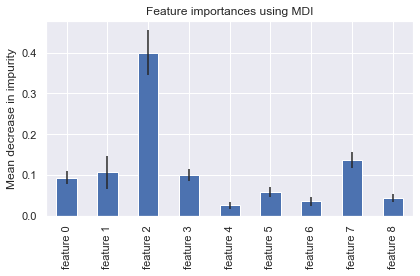

In [67]:
# Feature importance figure
feature_names = [f'feature {i}' for i in range(X_train_std_RF.shape[1])]

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [68]:
# Serie of selected features
features_serie = pd.Series(X_train.columns)
features_serie

0                                    YearBuilt
1                               NumberofFloors
2                             PropertyGFATotal
3                              ENERGYSTARScore
4                 energy_type_03_TargetEncoded
5                 energy_type_02_TargetEncoded
6                 energy_type_01_TargetEncoded
7    PrimaryPropertyType_new_cat_TargetEncoded
8            CouncilDistrictCode_TargetEncoded
dtype: object

### Selection of features with a threshold

In [69]:
# Threshold
select = SelectFromModel(model, prefit=True, threshold=0.01)
X_train_std_2 = select.transform(X_train_std_RF)
X_test_std_2 = select.transform(X_test_std)
print(X_train_std_2.shape)

(1811, 9)


### Training N°2 after selecting the 'most important features'

In [70]:
# Model instance
rfc2 = RandomForestClassifier(n_estimators=500, oob_score=True)

# Timer start
start_time = timeit.default_timer()

# Model fitting
rfc2 = rfc2.fit(X_train_std_2, y_train)

# Prediction
pred = rfc2.predict(X_test_std_2)

# Timer end
elapsed = timeit.default_timer() - start_time

# Performance
accuracy = accuracy_score(y_test, pred)

print("accuracy: {:.2f}; time: {:.2f}s".format(accuracy, elapsed))

accuracy: 0.81; time: 1.20s


In [71]:
# Get columns to keep and create new dataframe with those only
cols = select.get_support(indices=True)
features_df_new = X_train_std_RF.iloc[:,cols]
features_df_new

,YearBuilt,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,PrimaryPropertyType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded
0,-2.145130,0.180478,-0.240478,-0.770798,-0.223173,-1.224962,-0.479502,1.233723,1.267749
1,-0.286997,-0.150840,-0.462035,-0.550518,-0.092663,-1.140739,-0.254125,-0.552062,-0.123421
2,0.734977,-0.316499,0.566360,0.286547,-0.092663,-1.140739,-0.254125,1.291897,1.267749
3,0.084630,-0.482158,0.254722,-0.418350,-0.145777,0.682818,-0.333508,-0.587013,-0.123421
4,1.013697,0.180478,-0.431625,1.079555,-0.223173,-1.224962,-0.479502,-0.727121,-1.514591
...,...,...,...,...,...,...,...,...,...
1806,-1.370908,-0.150840,-0.197294,0.286547,-0.223173,0.635414,-0.479502,-0.727121,1.267749
1807,1.075635,-0.150840,-0.451265,1.079555,-0.223173,0.635414,-0.479502,-0.727121,1.267749
1808,0.580132,-0.316499,-0.396371,1.035499,-0.223173,-1.224962,-0.479502,-0.727121,-1.514591
1809,0.146568,0.014819,-0.128017,-0.638630,-0.092663,-1.140739,-0.254125,1.291897,0.340303


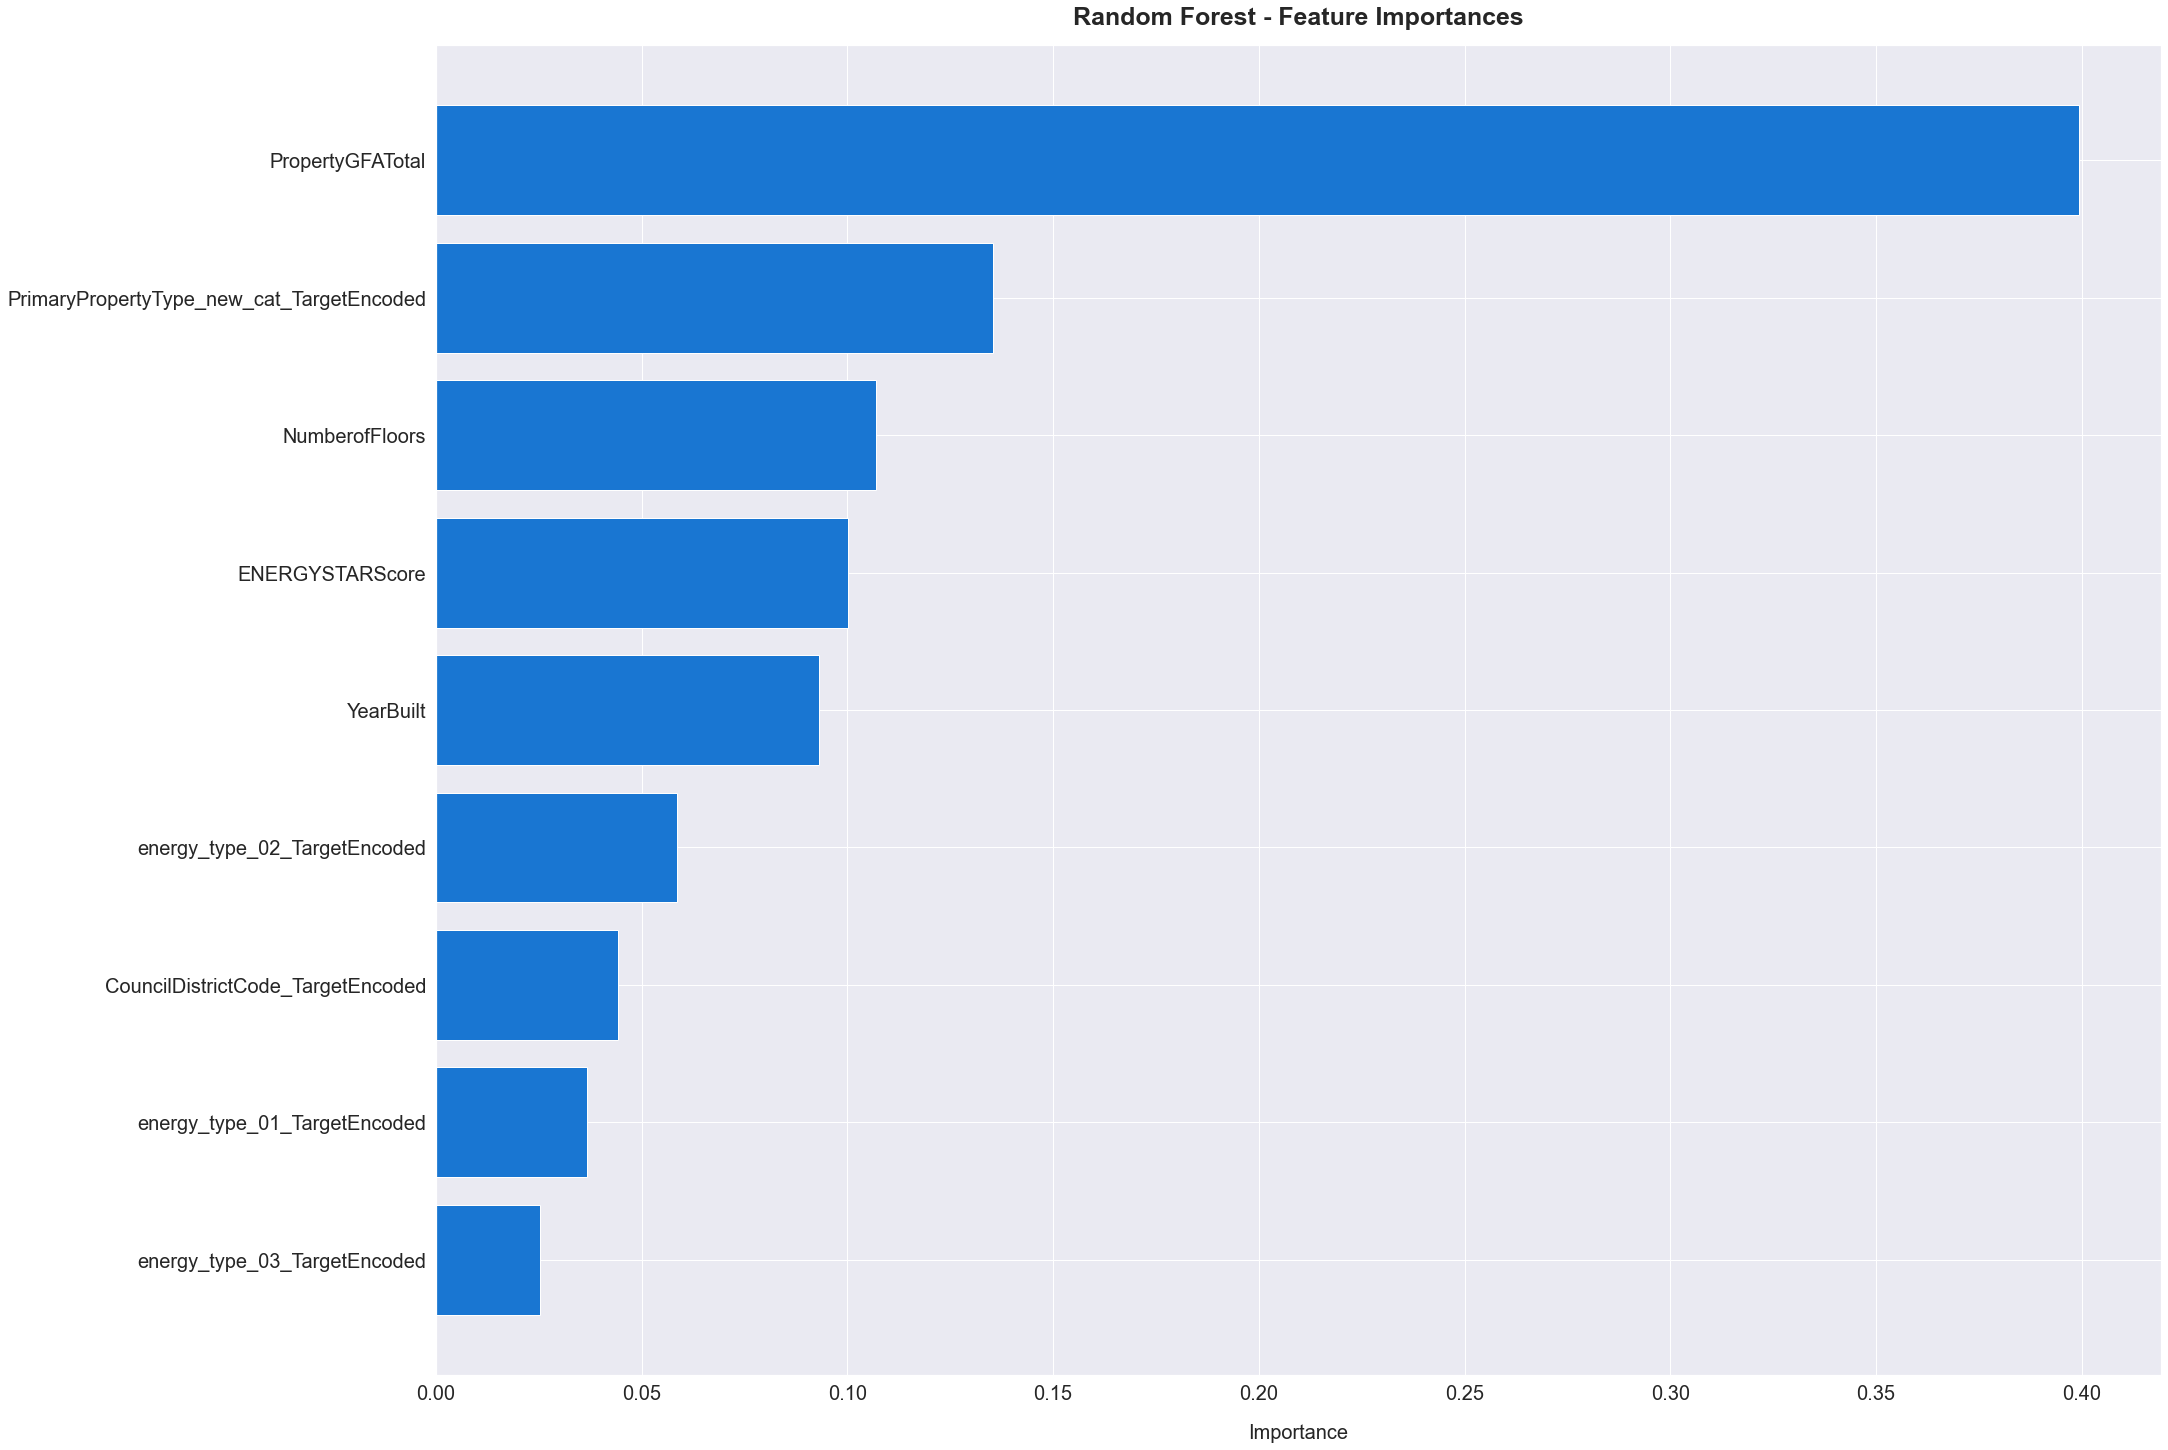

In [72]:
# Barplot of sorted features by importance 
dset = pd.DataFrame()
dset['attr'] = features_df_new.columns
dset['importance'] = rfc2.feature_importances_

dset = dset.sort_values(by='importance', ascending=True)

plt.figure(figsize=(30, 20), constrained_layout=True)
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest - Feature Importances', fontsize=25, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=20, labelpad=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# save
plt.savefig(f'projets\\04_seattle_building_energy\\production\\savefig\\{year}\\feature_selection\\feature_selectionRandom_forest_feature_importance.png', transparent=True, dpi=300)

plt.show()

In [73]:
# Performance
print("accuracy: {:.2f}; time: {:.2f}s".format(accuracy, elapsed))

accuracy: 0.81; time: 1.20s


This was only a manual feature selection without optimization

## Feature selection (RFECV - Random Forest)

In [74]:
# Copy of values to be trained and transformed
X_train_std_RFECV = X_train_std.copy()

In [75]:
# Model instance
rfc = RandomForestClassifier(random_state=101)

# RFECV instance
rfecv = RFECV(estimator=rfc, step=1, scoring='accuracy')

# Timer start
start_time = timeit.default_timer()

# Model fitting
rfecv.fit(X_train_std_RFECV , y_train)

# Prediction
pred = rfecv.predict(X_test_std)

# Timer end
elapsed = timeit.default_timer() - start_time

# Performance
accuracy = accuracy_score(y_test, pred)

print("accuracy: {:.2f}; time: {:.2f}s".format(accuracy, elapsed))

accuracy: 0.82; time: 7.98s


In [76]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 9


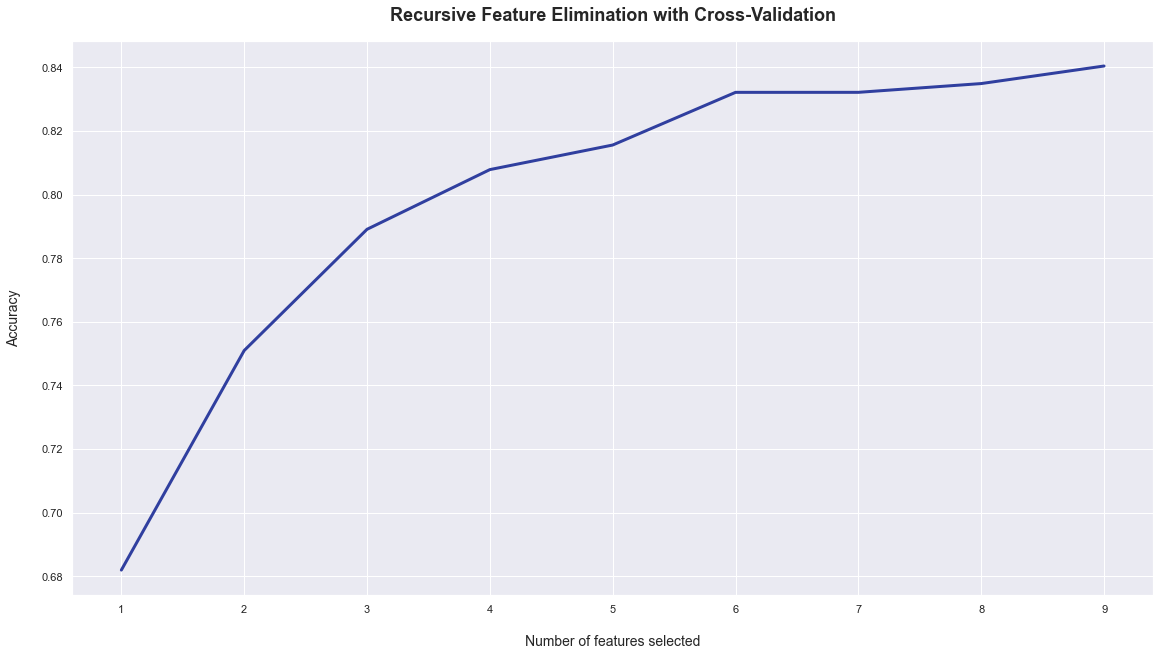

In [77]:
# Evolution of the performance with the number of features
plt.figure(figsize=(16, 9), constrained_layout=True)
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('Accuracy', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

# save
plt.savefig(f'projets\\04_seattle_building_energy\\production\\savefig\\{year}\\feature_selection\\feature_selection_RFECV_accuracy.png', transparent=True)

plt.show()

In [78]:
# Least important features

print(np.where(rfecv.support_ == False)[0])

X_train_std_RFECV .drop(X_train_std_RFECV .columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
X_train_std_RFECV 

[]


,YearBuilt,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,energy_type_03_TargetEncoded,energy_type_02_TargetEncoded,energy_type_01_TargetEncoded,PrimaryPropertyType_new_cat_TargetEncoded,CouncilDistrictCode_TargetEncoded
0,-2.145130,0.180478,-0.240478,-0.770798,-0.223173,-1.224962,-0.479502,1.233723,1.267749
1,-0.286997,-0.150840,-0.462035,-0.550518,-0.092663,-1.140739,-0.254125,-0.552062,-0.123421
2,0.734977,-0.316499,0.566360,0.286547,-0.092663,-1.140739,-0.254125,1.291897,1.267749
3,0.084630,-0.482158,0.254722,-0.418350,-0.145777,0.682818,-0.333508,-0.587013,-0.123421
4,1.013697,0.180478,-0.431625,1.079555,-0.223173,-1.224962,-0.479502,-0.727121,-1.514591
...,...,...,...,...,...,...,...,...,...
1806,-1.370908,-0.150840,-0.197294,0.286547,-0.223173,0.635414,-0.479502,-0.727121,1.267749
1807,1.075635,-0.150840,-0.451265,1.079555,-0.223173,0.635414,-0.479502,-0.727121,1.267749
1808,0.580132,-0.316499,-0.396371,1.035499,-0.223173,-1.224962,-0.479502,-0.727121,-1.514591
1809,0.146568,0.014819,-0.128017,-0.638630,-0.092663,-1.140739,-0.254125,1.291897,0.340303


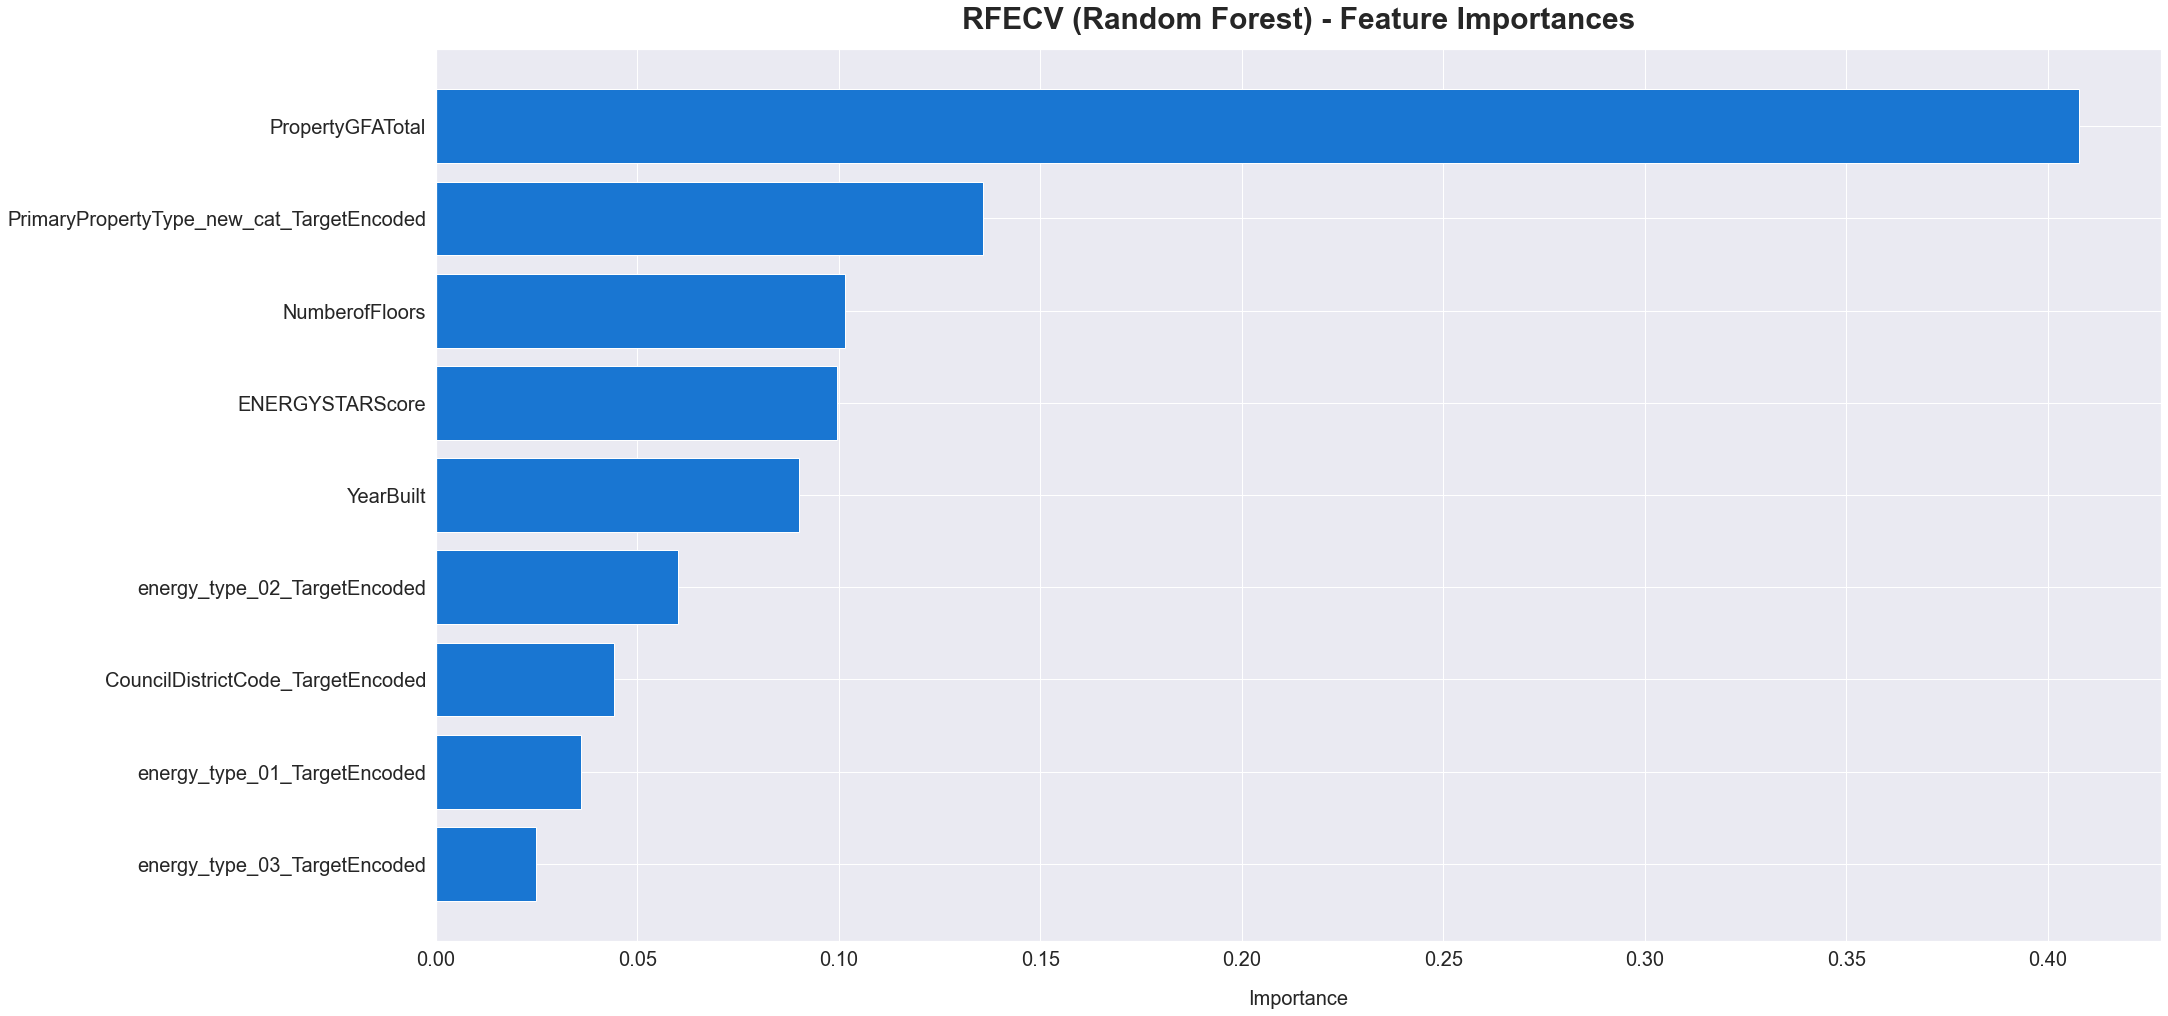

In [79]:
# Barplot of sorted features by importance 
dset = pd.DataFrame()
dset['attr'] = X_train_std_RFECV .columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=True)

plt.figure(figsize=(30, 14), constrained_layout=True)
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV (Random Forest) - Feature Importances', fontsize=30, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=20, labelpad=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# save
plt.savefig(f'projets\\04_seattle_building_energy\\production\\savefig\\{year}\\feature_selection\\feature_selection_RFECV.png', transparent=True)

plt.show()

In [80]:
# Performance
print("accuracy: {:.2f}; time: {:.2f}s".format(accuracy, elapsed))

accuracy: 0.82; time: 7.98s


### Features selected

In [81]:
# Choice 1
if ENERGYSTARScore_choice == 'yes':
    features_selected_lst = ['PropertyGFATotal', 'PrimaryPropertyType_new_cat_TargetEncoded',
                             'ENERGYSTARScore','NumberofFloors','YearBuilt',
                             'energy_type_02_TargetEncoded']
    features_selected_lst

In [82]:
# Choice 2
if ENERGYSTARScore_choice == 'no':
    features_selected_lst = ['PropertyGFATotal', 'PrimaryPropertyType_new_cat_TargetEncoded',
                             'NumberofFloors','YearBuilt', 'energy_type_02_TargetEncoded']
    features_selected_lst

# PREDICTIONS (VALIDATION)

## train/validation split with a numerical target

The columns are filtered with the selected features

The variables 'energy_type_02' and 'CouncilDistrictCode' are used with one-hot encoding and the least important features are deleted

Numerical target is used

In [83]:
# List of columns modified with ne_hot encoded variables

features_selected_lst.remove('energy_type_02_TargetEncoded')
features_selected_lst.remove('PrimaryPropertyType_new_cat_TargetEncoded')  

# Adding one_hot encoded variables
energy_type_lst = ['energy_type_02_<electricity>', 'energy_type_02_<gas>',
                     'energy_type_02_<steam>', 'energy_type_02_<Class Missing>']
    
PrimaryPropertyType_lst = ['PrimaryPropertyType_new_cat_<Commercial centers>',
                               'PrimaryPropertyType_new_cat_<Education>',
                               'PrimaryPropertyType_new_cat_<Health services>',
                               'PrimaryPropertyType_new_cat_<Hotel/Restaurant>',
                               'PrimaryPropertyType_new_cat_<Industry>',
                               'PrimaryPropertyType_new_cat_<Logistic/Distribution centers>',
                               'PrimaryPropertyType_new_cat_<Mixed Use Property>',
                               'PrimaryPropertyType_new_cat_<Multifamily Housing>',
                               'PrimaryPropertyType_new_cat_<Office>',
                               'PrimaryPropertyType_new_cat_<Other/Public places>',
                               'PrimaryPropertyType_new_cat_<Class Missing>']

district_lst = ['CouncilDistrictCode_<1>', 'CouncilDistrictCode_<2>', 'CouncilDistrictCode_<3>',
                'CouncilDistrictCode_<4>', 'CouncilDistrictCode_<5>', 'CouncilDistrictCode_<6>',
                'CouncilDistrictCode_<7>']

modified_features_selected_lst  = features_selected_lst + PrimaryPropertyType_lst + energy_type_lst + district_lst

In [84]:
modified_features_selected_lst

['PropertyGFATotal',
 'ENERGYSTARScore',
 'NumberofFloors',
 'YearBuilt',
 'PrimaryPropertyType_new_cat_<Commercial centers>',
 'PrimaryPropertyType_new_cat_<Education>',
 'PrimaryPropertyType_new_cat_<Health services>',
 'PrimaryPropertyType_new_cat_<Hotel/Restaurant>',
 'PrimaryPropertyType_new_cat_<Industry>',
 'PrimaryPropertyType_new_cat_<Logistic/Distribution centers>',
 'PrimaryPropertyType_new_cat_<Mixed Use Property>',
 'PrimaryPropertyType_new_cat_<Multifamily Housing>',
 'PrimaryPropertyType_new_cat_<Office>',
 'PrimaryPropertyType_new_cat_<Other/Public places>',
 'PrimaryPropertyType_new_cat_<Class Missing>',
 'energy_type_02_<electricity>',
 'energy_type_02_<gas>',
 'energy_type_02_<steam>',
 'energy_type_02_<Class Missing>',
 'CouncilDistrictCode_<1>',
 'CouncilDistrictCode_<2>',
 'CouncilDistrictCode_<3>',
 'CouncilDistrictCode_<4>',
 'CouncilDistrictCode_<5>',
 'CouncilDistrictCode_<6>',
 'CouncilDistrictCode_<7>']

In [85]:
# Target deleting
data_fix_set_train_val_random_bis_X = data_fix_set_train_val_random_freezed.copy()
data_fix_set_train_val_random_bis_X = data_fix_set_train_val_random_bis_X[modified_features_selected_lst]

In [86]:
# Definition of training values and targets
X_bis = data_fix_set_train_val_random_bis_X
y_bis = data_fix_set_train_val_random['SiteEnergyUseWN(kBtu)']

In [87]:
X_bis

,PropertyGFATotal,ENERGYSTARScore,NumberofFloors,YearBuilt,PrimaryPropertyType_new_cat_<Commercial centers>,PrimaryPropertyType_new_cat_<Education>,PrimaryPropertyType_new_cat_<Health services>,PrimaryPropertyType_new_cat_<Hotel/Restaurant>,PrimaryPropertyType_new_cat_<Industry>,PrimaryPropertyType_new_cat_<Logistic/Distribution centers>,PrimaryPropertyType_new_cat_<Mixed Use Property>,PrimaryPropertyType_new_cat_<Multifamily Housing>,PrimaryPropertyType_new_cat_<Office>,PrimaryPropertyType_new_cat_<Other/Public places>,PrimaryPropertyType_new_cat_<Class Missing>,energy_type_02_<electricity>,energy_type_02_<gas>,energy_type_02_<steam>,energy_type_02_<Class Missing>,CouncilDistrictCode_<1>,CouncilDistrictCode_<2>,CouncilDistrictCode_<3>,CouncilDistrictCode_<4>,CouncilDistrictCode_<5>,CouncilDistrictCode_<6>,CouncilDistrictCode_<7>
2588,88434,63.0,12.0,1927.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5177,103566,61.0,11.0,1996.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5178,956110,43.0,41.0,1969.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2591,175580,78.0,18.0,1980.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2592,83008,33.0,11.0,1926.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10350,81993,85.0,6.0,2014.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7760,25532,74.0,2.0,2014.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7761,44650,58.0,4.0,2000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2586,42393,99.0,7.0,2014.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [88]:
# Train test split
X_bis_train, X_bis_test, y_bis_train, y_bis_test = \
	train_test_split(X_bis, y_bis,
                     test_size=0.3 # 30% of data for testing
                    ,random_state=1)

In [89]:
# Data standardization
std_scale = preprocessing.StandardScaler().fit(X_bis_train)

X_bis_train_std = std_scale.transform(X_bis_train)
X_bis_test_std = std_scale.transform(X_bis_test)

In [90]:
# Creation of a dataframe to keep the feature names
X_bis_train_std = pd.DataFrame(X_bis_train_std, columns=X_bis_train.columns)
X_bis_test_std  = pd.DataFrame(X_bis_test_std , columns=X_bis_train.columns)

In [91]:
# Creation of a dictionnary to recolt the model results
train_model_model_results = {}

## Baseline : Dummy regression

In [92]:
# Model that always predicts the mean of the training set
dum = dummy.DummyRegressor(strategy='mean')

# Timer start
start_time = timeit.default_timer()

# Model fitting
dum.fit(X_bis_train_std, y_bis_train)

# Prediction
y_pred_dum = dum.predict(X_bis_test_std)

# Performance
baseline_error = np.sqrt(metrics.mean_squared_error(y_bis_test, y_pred_dum)) 
elapsed = timeit.default_timer() - start_time

print("RMSE - baseline : {:.2f}; time: {:.2f}s".format(baseline_error, elapsed))
train_model_model_results['regression/dummy'] = [baseline_error,0]

RMSE - baseline : 0.50; time: 0.00s


## Classic regression

In [93]:
# Model instance
lr = linear_model.LinearRegression()

# Timer start
start_time = timeit.default_timer()

# Model fitting
lr.fit(X_bis_train_std, y_bis_train)

# RMSE
error = np.sqrt(metrics.mean_squared_error(lr.predict(X_bis_test_std), y_bis_test))
elapsed = timeit.default_timer() - start_time

print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/classic'] = [error,elapsed]

RMSE: 0.30; temps: 0.03s/ RMSE - baseline: 0.50


## Ridge regression

In [94]:
# Parameters
n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)

In [95]:
# Model instance
ridge = linear_model.Ridge()

# Model fitting
coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    
    # Timer start
    start_time = timeit.default_timer()
    
    # Model fitting
    ridge.fit(X_bis_train_std, y_bis_train)
    coefs.append(ridge.coef_)
    
    # RMSE
    error = np.sqrt(metrics.mean_squared_error(ridge.predict(X_bis_test_std), y_bis_test))
    
    # Timer end
    elapsed = timeit.default_timer() - start_time
    
    # Performance
    errors.append([baseline_error, error])


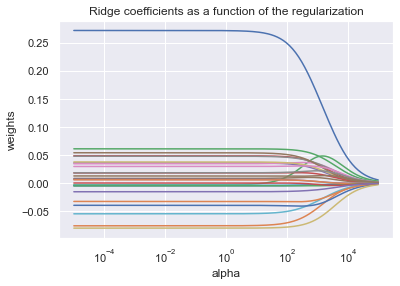

In [96]:
# Figure of Ridge coefficients
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [97]:
# Performance
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/ridge'] = [error,elapsed]

RMSE: 0.49; temps: 0.00s/ RMSE - baseline: 0.50


## Lasso Regression

In [98]:
# Parameters
n_alphas = 300
alphas = np.logspace(-5, 1, n_alphas)
lasso = linear_model.Lasso(fit_intercept=False)
errors = []

# Model fitting
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    
    # Timer start
    start_time = timeit.default_timer()
    
    # Model fitting
    lasso.fit(X_bis_train_std, y_bis_train)
    
    coefs.append(lasso.coef_)
    
    # RMSE
    error = np.sqrt(metrics.mean_squared_error(lasso.predict(X_bis_test_std), y_bis_test))
    
    # Timer end
    elapsed = timeit.default_timer() - start_time
    
    errors.append([baseline_error, error])

C:\Users\vince\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.507137316541, tolerance: 7.350558134710708
  model = cd_fast.enet_coordinate_descent(
C:\Users\vince\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.5073064847893, tolerance: 7.350558134710708
  model = cd_fast.enet_coordinate_descent(
C:\Users\vince\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 550.5074822837123, tolerance: 7.350558134710708
  model = cd_fast.enet_coordinate_descent(
C:\Users\vince\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

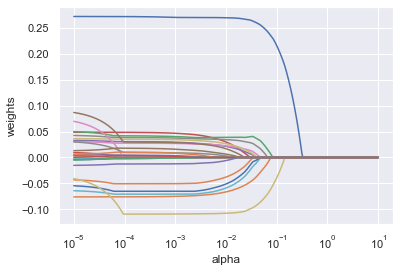

In [99]:
# Figure of Lasso coefficients
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

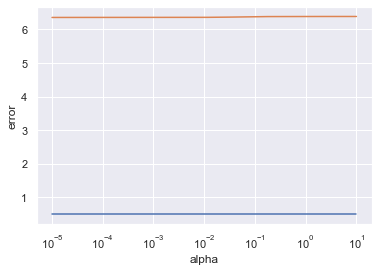

In [100]:
# Figure of Lasso error depending on alpha
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [101]:
# Performance
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/lasso'] = [error,elapsed]

RMSE: 6.39; temps: 0.00s/ RMSE - baseline: 0.50


## Decision Tree Regressor

In [102]:
# Fit the regressor, set max_depth = 3
dt_regr = DecisionTreeRegressor(max_depth=3, random_state=1234)

# Timer start
start_time = timeit.default_timer()

# Model fitting
model = dt_regr.fit(X_bis_train_std, y_bis_train)

# Error
error = np.sqrt(metrics.mean_squared_error(dt_regr.predict(X_bis_test_std), y_bis_test))

# Timer end
elapsed = timeit.default_timer() - start_time

# Performance
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/decision_tree'] = [error,elapsed]

RMSE: 0.29; temps: 0.00s/ RMSE - baseline: 0.50


In [103]:
# Tree representation
text_representation = tree.export_text(dt_regr)
print(text_representation)

|--- feature_0 <= 0.02
|   |--- feature_0 <= -0.36
|   |   |--- feature_18 <= 0.26
|   |   |   |--- value: [6.12]
|   |   |--- feature_18 >  0.26
|   |   |   |--- value: [5.89]
|   |--- feature_0 >  -0.36
|   |   |--- feature_18 <= 0.26
|   |   |   |--- value: [6.44]
|   |   |--- feature_18 >  0.26
|   |   |   |--- value: [6.23]
|--- feature_0 >  0.02
|   |--- feature_0 <= 0.85
|   |   |--- feature_0 <= 0.28
|   |   |   |--- value: [6.62]
|   |   |--- feature_0 >  0.28
|   |   |   |--- value: [6.83]
|   |--- feature_0 >  0.85
|   |   |--- feature_0 <= 2.68
|   |   |   |--- value: [7.18]
|   |   |--- feature_0 >  2.68
|   |   |   |--- value: [7.67]



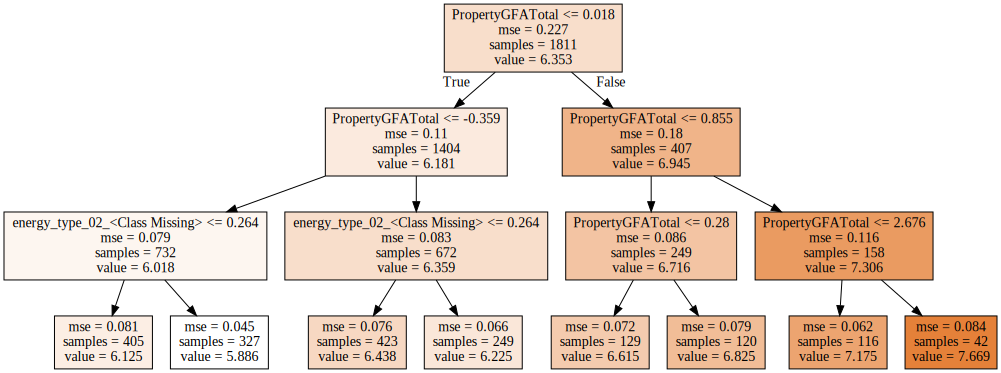

In [104]:
# graphviz 
dot_data = tree.export_graphviz(dt_regr, out_file=None, 
                                feature_names=modified_features_selected_lst,  
                                filled=True)
src = graphviz.Source(dot_data, format="png") 

# save fig
src.render(f'projets\\04_seattle_building_energy\\production\\savefig\\{year}\\model_results\\decision_tree.gv', view=True)

# show
src

In [105]:
# dtreeviz 

viz = dtreeviz(dt_regr,
               X_bis_train_std,
               y_bis_train,
               target_name='SiteEnergyUseWN(kBtu)',
               feature_names=modified_features_selected_lst)
              
viz.view()

### GridSearchCV

In [106]:
# Model instance
dt_gcv = GridSearchCV(estimator=dt_regr,
              param_grid={'min_samples_split': range(2, 10)},
    cv=5, refit=True)

# Timer start
start_time = timeit.default_timer()

# Model fitting
dt_gcv.fit(X_bis_train_std, y_bis_train)

# Best params
dt_gcv.best_params_

{'min_samples_split': 2}

In [107]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(dt_gcv.predict(X_bis_test_std), y_bis_test))
elapsed = timeit.default_timer() - start_time

# Performance
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/decision_tree_GSCV'] = [error,elapsed]

RMSE: 0.29; temps: 0.23s/ RMSE - baseline: 0.50


## Random forest Regressor

In [108]:
# Use the random grid to search for best hyperparameters
# Model instance
rf = RandomForestRegressor()

# Timer start
start_time = timeit.default_timer()

# Fit the search model
rf.fit(X_bis_train_std, y_bis_train)

RandomForestRegressor()

In [109]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(rf.predict(X_bis_test_std), y_bis_test))

# Timer end
elapsed = timeit.default_timer() - start_time

# Performance
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/random_forest'] = [error,elapsed]

RMSE: 0.22; temps: 0.60s/ RMSE - baseline: 0.50


### Random Hyperparameter Grid

- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [110]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 20, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [20, 50, 100, 200]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 30, 40, 50]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [500, 611, 722, 833, 944, 1055, 1166, 1277, 1388, 1500], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, None], 'min_samples_split': [20, 50, 100, 200], 'min_samples_leaf': [10, 30, 40, 50], 'bootstrap': [True]}


In [111]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3,
                               verbose=2, random_state=42, n_jobs = -1)
# Timer start
start_time = timeit.default_timer()
# Fit the random search model
rf_random.fit(X_bis_train_std, y_bis_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   46.9s finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [1, 2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [10, 30, 40, 50],
                                        'min_samples_split': [20, 50, 100, 200],
                                        'n_estimators': [500, 611, 722, 833,
                                                         944, 1055, 1166, 1277,
                                                         1388, 1500]},
                   random_state=42, verbose=2)

In [112]:
# Best parameters
rf_random.best_params_

{'n_estimators': 833,
 'min_samples_split': 20,
 'min_samples_leaf': 10,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [113]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(rf_random.predict(X_bis_test_std), y_bis_test))

# Timer end
elapsed = timeit.default_timer() - start_time

# Performance
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/random_forest_RHG'] = [error,elapsed]

RMSE: 0.24; temps: 49.52s/ RMSE - baseline: 0.50


### GridSearchCV

In [114]:
# Create the parameter grid 
param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 10, 12],
    #'max_features': [],
    'min_samples_leaf': [10, 100],
    #'min_samples_split': [],
    'n_estimators': [500, 1000, 1500]
}

# Instantiate the grid search model
rf_gcv = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Timer start
start_time = timeit.default_timer()
# Fit the grid search to the data
rf_gcv.fit(X_bis_train_std, y_bis_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  51 out of  54 | elapsed:   10.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   10.6s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [8, 10, 12],
                         'min_samples_leaf': [10, 100],
                         'n_estimators': [500, 1000, 1500]},
             verbose=2)

In [115]:
# Best params
rf_gcv.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'min_samples_leaf': 10,
 'n_estimators': 1000}

In [116]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(rf_gcv.predict(X_bis_test_std), y_bis_test))
# Timer end
elapsed = timeit.default_timer() - start_time
# Performance
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/random_forest_GSCV'] = [error,elapsed]

RMSE: 0.24; temps: 13.65s/ RMSE - baseline: 0.50


## XGBoost

In [117]:
# Model instance
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)
# Timer start
start_time = timeit.default_timer()

# Model fitting
xg_reg.fit(X_bis_train_std.values, y_bis_train)

# RMSE
error = np.sqrt(metrics.mean_squared_error(xg_reg.predict(X_bis_test), y_bis_test))

# Timer end
elapsed = timeit.default_timer() - start_time

# Performance
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/XGBoost'] = [error,elapsed]

RMSE: 1.11; temps: 0.01s/ RMSE - baseline: 0.50


### GridSearchCV 

In [118]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)], 'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

# Initialize XGB and GridSearch
grid_xgb = GridSearchCV(xg_reg, params)

# Timer start
start_time = timeit.default_timer()

# Model fitting
grid_xgb.fit(X_bis_train_std.values, y_bis_train)

# RMSE
error = np.sqrt(metrics.mean_squared_error(grid_xgb.predict(X_bis_test), y_bis_test))

# Timer end
elapsed = timeit.default_timer() - start_time

# Evaluation
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/XGBoost_GSCV'] = [error,elapsed]

RMSE: 0.80; temps: 24.76s/ RMSE - baseline: 0.50


## CatBoostRegressor

In [119]:
# Initialize data
# cat_features = [0,1,2]

# Initialize CatBoostRegressor
catb_reg = CatBoostRegressor(iterations=3, learning_rate=1, depth=5)

# Timer start
start_time = timeit.default_timer()

# Model fitting
catb_reg.fit(X_bis_train_std, y_bis_train)

# RMSE
error = np.sqrt(metrics.mean_squared_error(catb_reg.predict(X_bis_test_std), y_bis_test))

# Timer end
elapsed = timeit.default_timer() - start_time

# Evaluation
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/CATBoost'] = [error,elapsed]

0:	learn: 0.2712068	total: 139ms	remaining: 278ms
1:	learn: 0.2318582	total: 140ms	remaining: 69.9ms
2:	learn: 0.2207599	total: 141ms	remaining: 0us
RMSE: 0.24; temps: 0.18s/ RMSE - baseline: 0.50


### GridSearchCV

In [120]:
# Model instance
model = CatBoostRegressor()

# Grid parameters
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              }
# Gridsearch model instance
grid_cat = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)

# Timer start
start_time = timeit.default_timer()

# Model fitting
grid_cat.fit(X_bis_train_std, y_bis_train)


0:	learn: 0.4461739	total: 1.11ms	remaining: 110ms
1:	learn: 0.4195162	total: 2.31ms	remaining: 113ms
2:	learn: 0.3982656	total: 3.32ms	remaining: 107ms
3:	learn: 0.3774937	total: 4.31ms	remaining: 103ms
4:	learn: 0.3615814	total: 4.93ms	remaining: 93.7ms
5:	learn: 0.3446459	total: 5.9ms	remaining: 92.4ms
6:	learn: 0.3296983	total: 6.87ms	remaining: 91.3ms
7:	learn: 0.3154806	total: 7.87ms	remaining: 90.5ms
8:	learn: 0.3042386	total: 8.88ms	remaining: 89.7ms
9:	learn: 0.2929112	total: 9.9ms	remaining: 89.1ms
10:	learn: 0.2820996	total: 10.9ms	remaining: 88.6ms
11:	learn: 0.2742430	total: 12ms	remaining: 87.7ms
12:	learn: 0.2665245	total: 13ms	remaining: 86.8ms
13:	learn: 0.2599676	total: 14ms	remaining: 85.8ms
14:	learn: 0.2539544	total: 15ms	remaining: 85ms
15:	learn: 0.2490317	total: 16ms	remaining: 84.2ms
16:	learn: 0.2439365	total: 17.1ms	remaining: 83.5ms
17:	learn: 0.2396185	total: 18.1ms	remaining: 82.7ms
18:	learn: 0.2344951	total: 19.2ms	remaining: 81.9ms
19:	learn: 0.2294071	

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001FEB4ED0F40>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [121]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(grid_cat.predict(X_bis_test_std), y_bis_test))

# Timer end
elapsed = timeit.default_timer() - start_time

# Performance
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/CATBoost_GSCV'] = [error,elapsed]

RMSE: 0.20; temps: 4.99s/ RMSE - baseline: 0.50


## SVM 

In [122]:
# Model instance
svr_regr = svm.SVR(C=1.0, epsilon=0.2)

# Timer start
start_time = timeit.default_timer()

# Model fitting
svr_regr.fit(X_bis_train_std, y_bis_train)

# RMSE
error = np.sqrt(metrics.mean_squared_error(svr_regr.predict(X_bis_test_std), y_bis_test))

# Timer end
elapsed = timeit.default_timer() - start_time

# Performance
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/SVM'] = [error,elapsed]

RMSE: 0.25; temps: 0.06s/ RMSE - baseline: 0.50


### GridSearchCV

In [123]:
# Parameters
parameters = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100],'gamma': ['scale', 'auto']}

# Model instance
svr = svm.SVR()

# Gridsearch model instance
grid_svr = GridSearchCV(svr, parameters)

# Timer start
start_time = timeit.default_timer()

# Model fitting
grid_svr.fit(X_bis_train_std, y_bis_train)

# Timer end
elapsed = timeit.default_timer() - start_time

# Best params
grid_svr.best_params_

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

In [124]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(grid_svr.predict(X_bis_test_std), y_bis_test))

# Timer end
elapsed = timeit.default_timer() - start_time

# Performance
print("RMSE: {:.2f}; temps: {:.2f}s/ RMSE - baseline: {:.2f}".format(error, elapsed, baseline_error))
train_model_model_results['regression/SVM_GSCV'] = [error,elapsed]

RMSE: 0.24; temps: 264.27s/ RMSE - baseline: 0.50


## Results

In [125]:
# Results dictionnary
train_model_model_results

{'regression/dummy': [0.4970790981498224, 0],
 'regression/classic': [0.2973310393454734, 0.03157030000000205],
 'regression/ridge': [0.4874465782881852, 0.001796500000001089],
 'regression/lasso': [6.386755681075085, 0.0017153999999983682],
 'regression/decision_tree': [0.28625001490799395, 0.004413100000000725],
 'regression/decision_tree_GSCV': [0.28625001490799395, 0.22616179999999986],
 'regression/random_forest': [0.22272384542499132, 0.6020369000000017],
 'regression/random_forest_RHG': [0.237697237862864, 49.5231346],
 'regression/random_forest_GSCV': [0.23730003988616766, 13.647801200000004],
 'regression/XGBoost': [1.1085876300272273, 0.014490899999998419],
 'regression/XGBoost_GSCV': [0.7985518749278656, 24.762884099999994],
 'regression/CATBoost': [0.24457054163046524, 0.18165410000000293],
 'regression/CATBoost_GSCV': [0.20115917972236255, 4.986884100000012],
 'regression/SVM': [0.24682770484138633, 0.06130820000001336],
 'regression/SVM_GSCV': [0.23841377639734107, 264.27

In [126]:
# Results dataframe:
train_model_model_results_df = pd.DataFrame(list(train_model_model_results.items()),
                   columns=['Model', '[RMSE, Computing_time]'])

In [127]:
# Columns arranging
train_model_model_results_df['RMSE'] = train_model_model_results_df['[RMSE, Computing_time]'].apply(lambda x: round(x[0],2))
train_model_model_results_df['Computing_time'] = train_model_model_results_df['[RMSE, Computing_time]'].apply(lambda x: round(x[1],2))
train_model_model_results_df.drop('[RMSE, Computing_time]', axis=1, inplace=True)


In [128]:
train_model_model_results_df.sort_values(by=['RMSE'], inplace = True)
train_model_model_results_df

,Model,RMSE,Computing_time
12,regression/CATBoost_GSCV,0.20,4.99
6,regression/random_forest,0.22,0.60
7,regression/random_forest_RHG,0.24,49.52
8,regression/random_forest_GSCV,0.24,13.65
11,regression/CATBoost,0.24,0.18
14,regression/SVM_GSCV,0.24,264.27
13,regression/SVM,0.25,0.06
4,regression/decision_tree,0.29,0.00
5,regression/decision_tree_GSCV,0.29,0.23
1,regression/classic,0.30,0.03


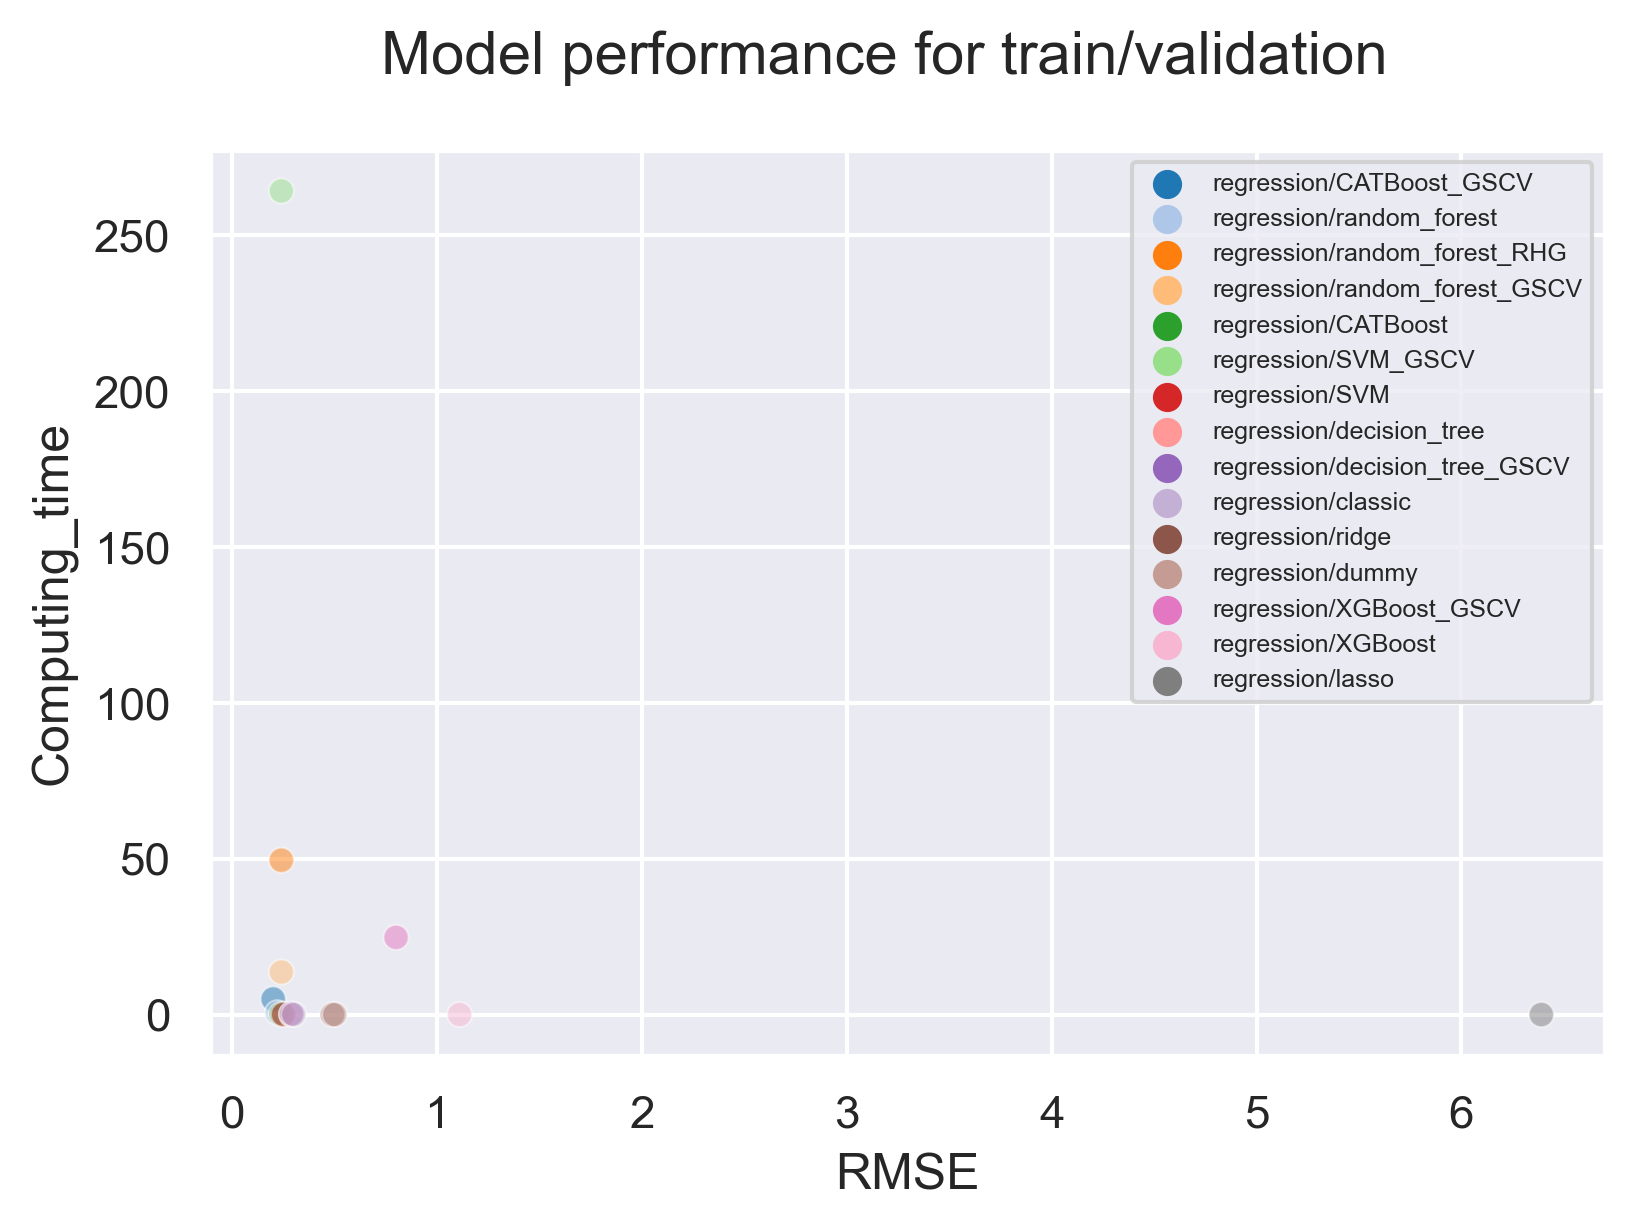

In [129]:
# Scatter plot of the results
my_pal = sns.color_palette("tab20", n_colors = train_model_model_results_df.shape[0])

# Fig, ax
fig, ax = plt.subplots(1, 1, dpi=300)
sns.scatterplot(data=train_model_model_results_df, x="RMSE", y="Computing_time", hue=train_model_model_results_df.Model, 
                palette=my_pal, 
                legend='full',
               alpha=0.5)

# Suptitle
fig.suptitle('Model performance for train/validation')

# Legend size and position
plt.legend(loc=1, prop={'size': 6})

# Save
fig.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{year}\\model_results\\Performance de modèles pour train-validation.png", transparent=True, dpi=300)

In [130]:
# Window zoom in configuration
x_max=0.6
y_max=10

In [131]:
# Filtered dataframe
train_model_model_results_df_filtered = train_model_model_results_df[train_model_model_results_df['RMSE']<x_max]
train_model_model_results_df_filtered = train_model_model_results_df_filtered[train_model_model_results_df['Computing_time']<y_max] 

C:\Users\vince\AppData\Local\Temp/ipykernel_34724/3454303208.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_model_model_results_df_filtered = train_model_model_results_df_filtered[train_model_model_results_df['Computing_time']<y_max]


In [132]:
# Sorting values
train_model_model_results_df_filtered.sort_values(by=['RMSE'], inplace = True)
train_model_model_results_df_filtered

,Model,RMSE,Computing_time
12,regression/CATBoost_GSCV,0.20,4.99
6,regression/random_forest,0.22,0.60
11,regression/CATBoost,0.24,0.18
13,regression/SVM,0.25,0.06
4,regression/decision_tree,0.29,0.00
5,regression/decision_tree_GSCV,0.29,0.23
1,regression/classic,0.30,0.03
2,regression/ridge,0.49,0.00
0,regression/dummy,0.50,0.00


In [133]:
# Model name changing for the figure
train_model_model_results_df_filtered['Model'] = train_model_model_results_df_filtered['Model'].apply(lambda x: x.replace("regression/", ""))
train_model_model_results_df_filtered

,Model,RMSE,Computing_time
12,CATBoost_GSCV,0.20,4.99
6,random_forest,0.22,0.60
11,CATBoost,0.24,0.18
13,SVM,0.25,0.06
4,decision_tree,0.29,0.00
5,decision_tree_GSCV,0.29,0.23
1,classic,0.30,0.03
2,ridge,0.49,0.00
0,dummy,0.50,0.00


In [134]:
# Model name changing for the figure
train_model_model_results_df_filtered['Model'] = train_model_model_results_df_filtered['Model'].apply(lambda x: x.replace("Boost", "B"))
train_model_model_results_df_filtered

,Model,RMSE,Computing_time
12,CATB_GSCV,0.20,4.99
6,random_forest,0.22,0.60
11,CATB,0.24,0.18
13,SVM,0.25,0.06
4,decision_tree,0.29,0.00
5,decision_tree_GSCV,0.29,0.23
1,classic,0.30,0.03
2,ridge,0.49,0.00
0,dummy,0.50,0.00


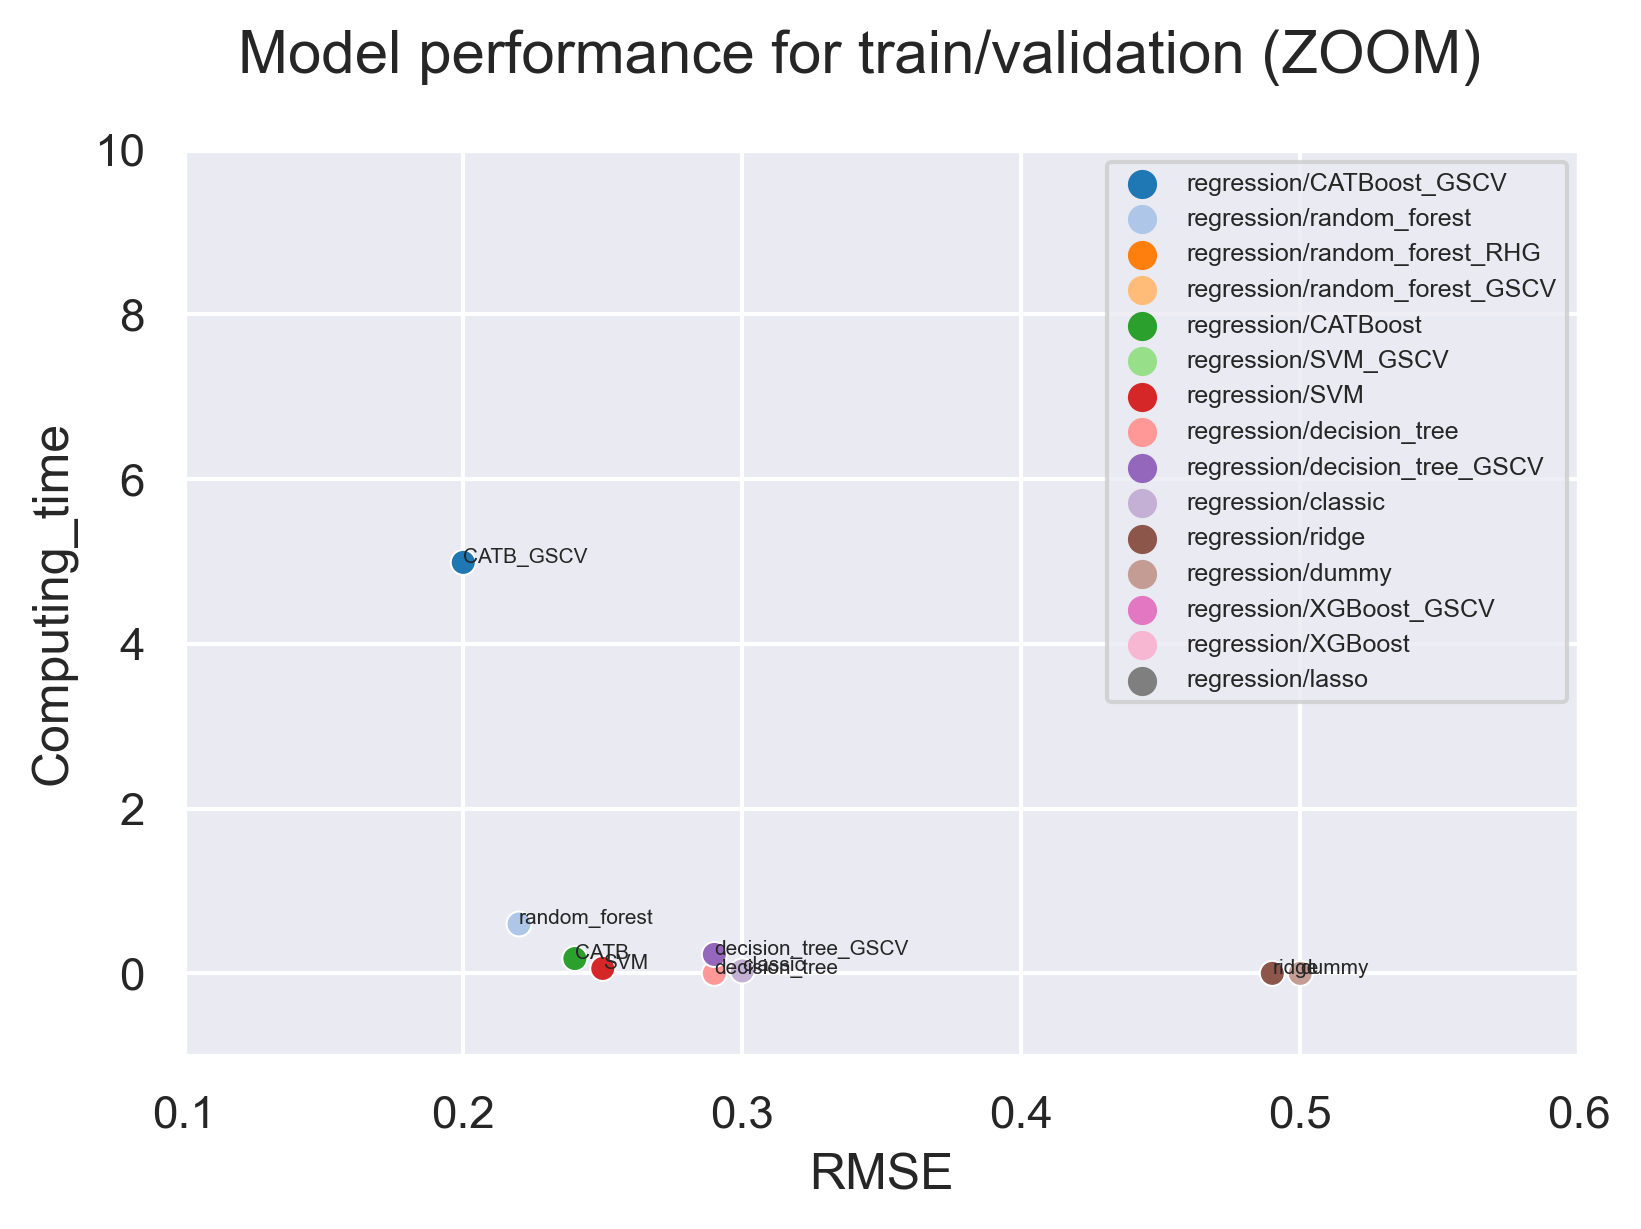

In [135]:
# Scatter plot with a zoom of the results 
# Color palette
my_pal = sns.color_palette("tab20", n_colors = train_model_model_results_df.shape[0])

# Fig, ax
fig, ax = plt.subplots(1, 1, dpi=300)

# Scatterplot
sns.scatterplot(data=train_model_model_results_df, x="RMSE", y="Computing_time", hue=train_model_model_results_df.Model, 
                palette=my_pal, 
                legend='full')

# Figure title
fig.suptitle('Model performance for train/validation (ZOOM)')

# Legend size and position
plt.legend(loc=1, prop={'size': 6})

# axes limits:
ax.set_xlim(0.1, x_max)
ax.set_ylim(-1, y_max)

# text size parameter
size = 5

# texting
for i in range(train_model_model_results_df_filtered.shape[0]):
    plt.text(train_model_model_results_df_filtered['RMSE'].iloc[i],
             train_model_model_results_df_filtered['Computing_time'].iloc[i],
             train_model_model_results_df_filtered['Model'].iloc[i], size=size)

# Save
fig.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{year}\\model_results\\Performance de modèles pour train-validation (ZOOM).png", transparent=True, dpi=300)

# Calculation of the WN coefficients between 'SiteEnergyUse(kBtu)' and 'SiteEnergyUseWN(kBtu)'




2018
Number of points: 2588 dont train: 1800
Coefficients: 
 [[0.99202466]]
Mean squre error: 92979465185.53
Determination coefficient: 1.00
WN Coefficient: 0.992


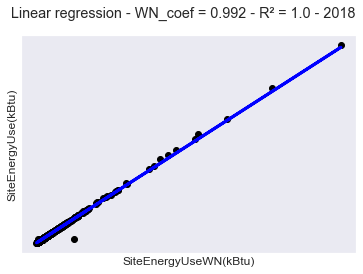




2017
Number of points: 2588 dont train: 1800
Coefficients: 
 [[1.00690089]]
Mean squre error: 49447602385.39
Determination coefficient: 1.00
WN Coefficient: 1.007


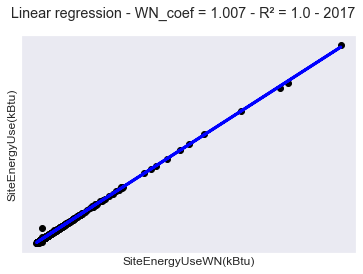




2016
Number of points: 2588 dont train: 1800
Coefficients: 
 [[0.98748313]]
Mean squre error: 48694699562.35
Determination coefficient: 1.00
WN Coefficient: 0.987


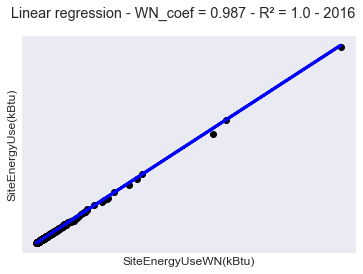




2015
Number of points: 2588 dont train: 1800
Coefficients: 
 [[0.98164029]]
Mean squre error: 148763334604.74
Determination coefficient: 0.99
WN Coefficient: 0.982


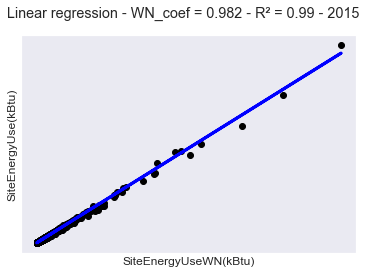




2019
Number of points: 2588 dont train: 1800
Coefficients: 
 [[0.98911304]]
Mean squre error: 1332541076250.41
Determination coefficient: 0.95
WN Coefficient: 0.989


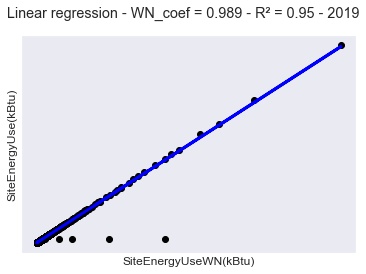




2020
Number of points: 2518 dont train: 1800
Coefficients: 
 [[1.00406169]]
Mean squre error: 401907378036.84
Determination coefficient: 0.98
WN Coefficient: 1.004


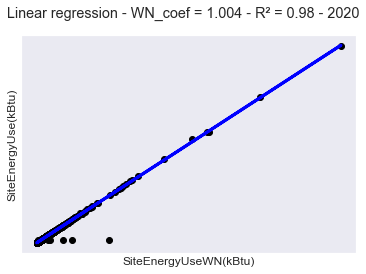

In [136]:
# WN coefficients for year_minus_1,year_minus_2,year_minus_3,year_minus_4,year,year_plus_1:

WN_coef = {}

for data_year in [year_minus_1,year_minus_2,year_minus_3,year_minus_4,year,year_plus_1]:
    
    # Creation of a dataframe filtered on the year
    df = data_fix_set[data_year].copy()
    df_year = df[df['DataYear'] == int(data_year)]
    
    # Transformation from log to exp:
    df_year['SiteEnergyUseWN(kBtu)_bis'] = df_year['SiteEnergyUseWN(kBtu)'].apply(lambda x: np.power(10,x))
    df_year['SiteEnergyUse(kBtu)_bis'] = df_year['SiteEnergyUse(kBtu)'].apply(lambda x: np.power(10,x))
    
    # Train/test split of the input
    energy_X_train = df_year['SiteEnergyUseWN(kBtu)_bis'][:-1800].values.reshape(-1, 1)
    energy_X_test = df_year['SiteEnergyUseWN(kBtu)_bis'][-1800:].values.reshape(-1, 1)

    # Train/test split of the target
    energy_y_train = df_year['SiteEnergyUse(kBtu)_bis'][:-1800].values.reshape(-1, 1)
    energy_y_test = df_year['SiteEnergyUse(kBtu)_bis'][-1800:].values.reshape(-1, 1)

    # Model instance
    regr = linear_model.LinearRegression()

    # Model fitting
    regr.fit(energy_X_train, energy_y_train)

    # Prediction
    energy_y_pred = regr.predict(energy_X_test)
        
    # Year print
    print("\n\n")
    print(int(data_year))
    
    # Number of points:
    print(f"Number of points: {df_year.shape[0]} dont train: 1800")
    
    # Model coefficients
    print('Coefficients: \n', regr.coef_)
    
    # MSE
    MSE = mean_squared_error(energy_y_test, energy_y_pred)
    print('Mean squre error: %.2f'
          % MSE)
    
    # R²
    R2 = r2_score(energy_y_test, energy_y_pred)
    print('Determination coefficient: %.2f'
          % R2)
    
    # WN coeff saving
    WN_coef_save = regr.coef_[0][0]
    WN_coef[str(data_year)] = round(WN_coef_save, 3)
    
    # Printing
    print('WN Coefficient: %.3f'
          % WN_coef[data_year]) 
    
    # Output plot 
    plt.scatter(energy_X_test, energy_y_test,  color='black')
    plt.plot(energy_X_test, energy_y_pred, color='blue', linewidth=3)

    plt.xlabel('SiteEnergyUseWN(kBtu)')
    plt.ylabel('SiteEnergyUse(kBtu)')
    plt.suptitle(f"Linear regression - WN_coef = {WN_coef[data_year]} - R² = {round(R2,2)} - {int(data_year)}")

    plt.xticks(())
    plt.yticks(())
        
    # Save
    file = int(data_year)
    plt.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{file}\\regression_energyWN_energy_{file}.png", transparent=True)
    
    # Show
    plt.show()


In [137]:
# WN coefficients per year
for data_year in [year_minus_1,year_minus_2,year_minus_3,year,year_plus_1]:
    print(f"{data_year} - WN_coef: {WN_coef[data_year]}")

2018 - WN_coef: 0.992
2017 - WN_coef: 1.007
2016 - WN_coef: 0.987
2019 - WN_coef: 0.989
2020 - WN_coef: 1.004


# TEST DATASET (INPUTS OF THE FIX SET)

'NumberofBuildings' is not selected by the RFECV, it is not necessary to add this column when missing depending on the year

## Input of buildings in the fix set

The predicted years are "year" and "year_plus_1". We are looking for the new inputs of the fix set those years as well. This buildings data is new for the algorithm

In [138]:
# New input of the fix set in 'year'

# List of buildings entering the fix set and not in fix_lst_base:
liste = []

# Buildings in 'year_plus_1':
list_plus_1 = list(data[year_plus_1]['OSEBuildingID'].unique())

# Inputs in 'year' are buildings followed from 'year_minus_2':
for building in list_minus_2:
    if (
        (building not in fix_lst_base) and
        (building in list_minus_1) and 
        (building in list_0) and 
        (building in list_plus_1)):
        liste.append(building)

# Creation of a unique list
fix_lst_base_input_year = []

# Looking for buildings not in the initial list
for building in liste:
    if building not in fix_lst_base_input_year:
        fix_lst_base_input_year.append(building)
        
len(fix_lst_base_input_year)

311

In [139]:
print(f"{len(fix_lst_base_input_year)} bâtiments à tester en {year}")

311 bâtiments à tester en 2019


In [140]:
# ratio of new buildings in 'year'
ratio = round(len(fix_lst_base_input_year)/len(fix_lst_base),2)

In [141]:
print(f"Représente une taille équivalente à {ratio*100}% du set train/validation")

Représente une taille équivalente à 12.0% du set train/validation


In [142]:
# New input of the fix set in 'year_plus_1'

# List of buildings entering the fix set and not in fix_lst_base:
liste = []

# Buildings in 'year_plus_1':
list_plus_1 = list(data[year_plus_1]['OSEBuildingID'].unique())

# Inputs in 'year_plus_1' are buildings followed from 'year_minus_1':
for building in list_minus_1:
    if (
        (building not in fix_lst_base) and
        (building in list_0) and 
        (building in list_plus_1)):
        liste.append(building)
    
# Creation of a unique list
fix_lst_base_input_year_plus_1 = []

# Looking for buildings not in the initial list
for building in liste:
    if building not in fix_lst_base_input_year_plus_1:
        fix_lst_base_input_year_plus_1.append(building)
        
len(fix_lst_base_input_year_plus_1)

618

In [143]:
print(f"{len(fix_lst_base_input_year_plus_1)} bâtiments à tester en {year_plus_1}")

618 bâtiments à tester en 2020


In [144]:
# ratio of new buildings in 'year_plus_1'
ratio = round(len(fix_lst_base_input_year_plus_1)/len(fix_lst_base),2)

In [145]:
print(f"Représente une taille équivalente à {ratio*100}% du set train/validation")

Représente une taille équivalente à 24.0% du set train/validation


## Creation of the test dataset

In [146]:
# Filter on the fix set in 'year':

data_fix_set_test_0 = data[year][data[year]['OSEBuildingID'].isin(fix_lst_base_input_year)]
data_fix_set_test_0.shape

(311, 70)

In [147]:
# Filter on the fix set in 'year_plus_1':
data_fix_set_test_plus_1 = data[year_plus_1][data[year_plus_1]['OSEBuildingID'].isin(fix_lst_base_input_year_plus_1)]
data_fix_set_test_plus_1.shape

(618, 71)

In [148]:
# Dictionnary of dataframes of new inputs per year in the fix set 

data_fix_set_test = {}
for data_year in [year, year_plus_1]:

    if data_year == year:
        data_fix_set_test[str(data_year)] = data_fix_set_test_0.copy()
        
    if data_year == year_plus_1:
        data_fix_set_test[str(year_plus_1)] = data_fix_set_test_plus_1.copy()

# ENERGY PREDICTION - TEST - {year}

In [149]:
# We keep the same columns than for the training
columns_keep = data_fix_set_train_val_random.columns

## Test set (a: buildings of fix_set_base in {year_minus_1})

In [150]:
# Results dictionnary
a_year_model_results = {}

In [151]:
# Target deleting
data_fix_set_test_X_a = data_fix_set[year].copy()
data_fix_set_test_X_a = data_fix_set_test_X_a[modified_features_selected_lst]

In [152]:
column_data_rate(data_fix_set_test_X_a)

PropertyGFATotal                                               1.0
ENERGYSTARScore                                                1.0
NumberofFloors                                                 1.0
YearBuilt                                                      1.0
PrimaryPropertyType_new_cat_<Commercial centers>               1.0
PrimaryPropertyType_new_cat_<Education>                        1.0
PrimaryPropertyType_new_cat_<Health services>                  1.0
PrimaryPropertyType_new_cat_<Hotel/Restaurant>                 1.0
PrimaryPropertyType_new_cat_<Industry>                         1.0
PrimaryPropertyType_new_cat_<Logistic/Distribution centers>    1.0
PrimaryPropertyType_new_cat_<Mixed Use Property>               1.0
PrimaryPropertyType_new_cat_<Multifamily Housing>              1.0
PrimaryPropertyType_new_cat_<Office>                           1.0
PrimaryPropertyType_new_cat_<Other/Public places>              1.0
PrimaryPropertyType_new_cat_<Class Missing>                   

In [153]:
X2_a = data_fix_set_test_X_a.values 
y2_a = data_fix_set[year]['SiteEnergyUseWN(kBtu)'].values

In [154]:
# Same standardization than the training part
X2_a_std = std_scale.transform(X2_a)

### Baseline: dummy regression

In [155]:
# Prediction
y2_a_pred_dum = dum.predict(X2_a_std)*(WN_coef[year])

# RMSE
baseline_error_2_a = np.sqrt(metrics.mean_squared_error(y2_a, y2_a_pred_dum)) 

# Performance
print("RMSE - baseline test a : {:.2f}".format(baseline_error_2_a))
a_year_model_results['regression/dummy'] = baseline_error_2_a

RMSE - baseline test a : 0.49


### Decision Tree Regressor

In [156]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y2_a_pred = dt_regr.predict(X2_a_std)*(WN_coef[year])

In [157]:
# Copy for later
y2_a_pred_year = y2_a_pred

In [158]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y2_a_pred, y2_a))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test a: {:.2f}".format(error, baseline_error_2_a))
a_year_model_results['regression/decision_tree'] = error

RMSE: 0.28/ RMSE - baseline test a: 0.49


### Random forest Regressor

In [159]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y2_a_pred = rf.predict(X2_a_std)*(WN_coef[year])

In [160]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y2_a_pred, y2_a))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test a: {:.2f}".format(error, baseline_error_2_a))
a_year_model_results['regression/random_forest'] = error

RMSE: 0.19/ RMSE - baseline test a: 0.49


### CatBoostRegressor

In [161]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y2_a_pred = catb_reg.predict(X2_a_std)*(WN_coef[year])

In [162]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y2_a_pred, y2_a))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_2_a))
a_year_model_results['regression/CATBoost'] = error

RMSE: 0.24/ RMSE - baseline test b: 0.49


### SVM regressor

In [163]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y2_a_pred = svr_regr.predict(X2_a_std)*(WN_coef[year])

In [164]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y2_a_pred, y2_a))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_2_a))
a_year_model_results['regression/SVM'] = error

RMSE: 0.24/ RMSE - baseline test b: 0.49


## Test set (b: inputs of the fix set)

In [165]:
# Results dictionnary
b_year_model_results = {}

In [166]:
# Target deleting
data_fix_set_test_X_b = data_fix_set_test[year].copy()
data_fix_set_test_X_b = data_fix_set_test_X_b[modified_features_selected_lst]

In [167]:
# Columns filling rate
column_data_rate(data_fix_set_test_X_b)

PropertyGFATotal                                               1.0
ENERGYSTARScore                                                1.0
NumberofFloors                                                 1.0
YearBuilt                                                      1.0
PrimaryPropertyType_new_cat_<Commercial centers>               1.0
PrimaryPropertyType_new_cat_<Education>                        1.0
PrimaryPropertyType_new_cat_<Health services>                  1.0
PrimaryPropertyType_new_cat_<Hotel/Restaurant>                 1.0
PrimaryPropertyType_new_cat_<Industry>                         1.0
PrimaryPropertyType_new_cat_<Logistic/Distribution centers>    1.0
PrimaryPropertyType_new_cat_<Mixed Use Property>               1.0
PrimaryPropertyType_new_cat_<Multifamily Housing>              1.0
PrimaryPropertyType_new_cat_<Office>                           1.0
PrimaryPropertyType_new_cat_<Other/Public places>              1.0
PrimaryPropertyType_new_cat_<Class Missing>                   

In [168]:
# Values
X2_b = data_fix_set_test_X_b.values 
y2_b = data_fix_set_test[year]['SiteEnergyUseWN(kBtu)'].values

In [169]:
# Standardization like the train part
X2_b_std = std_scale.transform(X2_b)

### Baseline: dummy regression

In [170]:
# Prediction
y2_b_pred_dum = dum.predict(X2_b_std)*(WN_coef[year])

# RMSE
baseline_error_2_b = np.sqrt(metrics.mean_squared_error(y2_b, y2_b_pred_dum)) 

# Performance
print("RMSE : {:.2f}".format(baseline_error_2_b))
b_year_model_results['regression/dummy'] = baseline_error_2_b

RMSE : 0.55


### Decision Tree Regressor

In [171]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y2_b_pred = dt_regr.predict(X2_b_std)*(WN_coef[year])

In [172]:
# Copy for later
y2_b_pred_year = y2_b_pred

In [173]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y2_b_pred, y2_b))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test a: {:.2f}".format(error, baseline_error_2_b))
b_year_model_results['regression/decision_tree'] = error

RMSE: 0.32/ RMSE - baseline test a: 0.55


### Random forest Regressor

In [174]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y2_b_pred = rf.predict(X2_b_std)*(WN_coef[year])

In [175]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y2_b_pred, y2_b))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test a: {:.2f}".format(error, baseline_error_2_b))
b_year_model_results['regression/random_forest'] = error

RMSE: 0.28/ RMSE - baseline test a: 0.55


### CatBoostRegressor

In [176]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y2_b_pred = catb_reg.predict(X2_b_std)*(WN_coef[year])

In [177]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y2_b_pred, y2_b))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_2_b))
b_year_model_results['regression/CATBoost'] = error

RMSE: 0.30/ RMSE - baseline test b: 0.55


### SVM regressor

In [178]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y2_b_pred = svr_regr.predict(X2_b_std)*(WN_coef[year])

In [179]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y2_b_pred, y2_b))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_2_b))
b_year_model_results['regression/SVM'] = error

RMSE: 0.32/ RMSE - baseline test b: 0.55


## Results

In [180]:
# dataframe results - year - a:
a_year_model_results_df = pd.DataFrame(list(a_year_model_results.items()),
                   columns=['Model', 'RMSE'])
a_year_model_results_df['RMSE'] = a_year_model_results_df['RMSE'].apply(lambda x: round(x,2))

a_year_model_results_df[f'Set_part_{year}'] = 'a'

a_year_model_results_df.sort_values(by=['RMSE'], inplace=True)

# Set index
a_year_model_results_df.set_index([pd.Index([1, 2, 3, 4, 5]), f'Set_part_{year}'])


,,Model,RMSE
,Set_part_2019,,
1,a,regression/random_forest,0.19
2,a,regression/CATBoost,0.24
3,a,regression/SVM,0.24
4,a,regression/decision_tree,0.28
5,a,regression/dummy,0.49


In [181]:
# dataframe results - year - b:
b_year_model_results_df = pd.DataFrame(list(b_year_model_results.items()),
                   columns=['Model', 'RMSE'])
b_year_model_results_df['RMSE'] = b_year_model_results_df['RMSE'].apply(lambda x: round(x,2))

b_year_model_results_df[f'Set_part_{year}'] = 'b'

# Sorting and setting index
b_year_model_results_df.sort_values(by=['RMSE'], inplace= True)
b_year_model_results_df.set_index([pd.Index([1, 2, 3, 4, 5]), f'Set_part_{year}'])

,,Model,RMSE
,Set_part_2019,,
1,b,regression/random_forest,0.28
2,b,regression/CATBoost,0.30
3,b,regression/decision_tree,0.32
4,b,regression/SVM,0.32
5,b,regression/dummy,0.55


## Target predicted

In [182]:
# Copy for later
energy_target_year_predicted_df_01 = pd.DataFrame(y2_a_pred_year, columns=[f'SiteEnergyUse(kBtu)_predicted_{year}'])
energy_target_year_predicted_df_02 = pd.DataFrame(y2_b_pred_year, columns=[f'SiteEnergyUse(kBtu)_predicted_{year}'])
energy_target_year_predicted_df = pd.concat([energy_target_year_predicted_df_01, energy_target_year_predicted_df_02])
energy_target_year_predicted_df.reset_index(drop=True, inplace=True)
energy_target_year_predicted_df

,SiteEnergyUse(kBtu)_predicted_2019
0,6.366729
1,6.542415
2,7.584474
3,6.750004
4,6.366729
...,...
2894,7.096162
2895,7.584474
2896,6.366729
2897,6.057612


# ENERGY PREDICTION - TEST - {year_plus_1}

## Test set (a: buildings of fix_set_base in {year_minus_1})

In [183]:
# Result dictionnary
a_year_plus_1_model_results = {}

In [184]:
# Target deleting
data_fix_set_test_X_a = data_fix_set[year_plus_1].copy()
data_fix_set_test_X_a = data_fix_set_test_X_a[modified_features_selected_lst]

In [185]:
# Column filling rate
column_data_rate(data_fix_set_test_X_a)

PropertyGFATotal                                               1.0
ENERGYSTARScore                                                1.0
NumberofFloors                                                 1.0
YearBuilt                                                      1.0
PrimaryPropertyType_new_cat_<Commercial centers>               1.0
PrimaryPropertyType_new_cat_<Education>                        1.0
PrimaryPropertyType_new_cat_<Health services>                  1.0
PrimaryPropertyType_new_cat_<Hotel/Restaurant>                 1.0
PrimaryPropertyType_new_cat_<Industry>                         1.0
PrimaryPropertyType_new_cat_<Logistic/Distribution centers>    1.0
PrimaryPropertyType_new_cat_<Mixed Use Property>               1.0
PrimaryPropertyType_new_cat_<Multifamily Housing>              1.0
PrimaryPropertyType_new_cat_<Office>                           1.0
PrimaryPropertyType_new_cat_<Other/Public places>              1.0
PrimaryPropertyType_new_cat_<Class Missing>                   

In [186]:
# Values
X3_a = data_fix_set_test_X_a.values # à standardiser comme train/val set
y3_a = data_fix_set[year_plus_1]['SiteEnergyUseWN(kBtu)'].values

In [187]:
# Standardization
X3_a_std = std_scale.transform(X3_a)

### Baseline: dummy regression

In [188]:
# Prediction
y3_a_pred_dum = dum.predict(X3_a_std)*(WN_coef[year_plus_1])

# RMSE
baseline_error_3_a = np.sqrt(metrics.mean_squared_error(y3_a, y3_a_pred_dum)) 

# Performance
print("RMSE - baseline test a : {:.2f}".format(baseline_error_3_a))
a_year_plus_1_model_results['regression/dummy'] = baseline_error_3_a

RMSE - baseline test a : 0.47


### Decision Tree Regressor

In [189]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y3_a_pred = dt_regr.predict(X3_a_std)*(WN_coef[year_plus_1])


In [190]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y3_a_pred, y3_a))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_a))
a_year_plus_1_model_results['regression/decision_tree'] = error

RMSE: 0.27/ RMSE - baseline test b: 0.47


### Random forest Regressor

In [191]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y3_a_pred = rf.predict(X3_a_std)*(WN_coef[year_plus_1])

In [192]:
# RMSE
errors = np.sqrt(metrics.mean_squared_error(y3_a_pred, y3_a))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test a: {:.2f}".format(error, baseline_error_3_a))
a_year_plus_1_model_results['regression/random_forest'] = error

RMSE: 0.27/ RMSE - baseline test a: 0.47


### CatBoostRegressor

In [193]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y3_a_pred = catb_reg.predict(X3_a_std)*(WN_coef[year_plus_1])

In [194]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y3_a_pred, y3_a))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_a))
a_year_plus_1_model_results['regression/CATBoost'] = error

RMSE: 0.24/ RMSE - baseline test b: 0.47


### SVM regressor

In [195]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y3_a_pred = svr_regr.predict(X3_a_std)*(WN_coef[year_plus_1])

In [196]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y3_a_pred, y3_a))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_a))
a_year_plus_1_model_results['regression/SVM'] = error

RMSE: 0.25/ RMSE - baseline test b: 0.47


## Test set (b: inputs of the fix set)

In [197]:
# Result dictionnary
b_year_plus_1_model_results = {}

In [198]:
# Target deleting
data_fix_set_test_X_b = data_fix_set_test[year_plus_1].copy()
data_fix_set_test_X_b = data_fix_set_test_X_b[modified_features_selected_lst]

In [199]:
# Column filling rate
column_data_rate(data_fix_set_test_X_b)

PropertyGFATotal                                               1.0
ENERGYSTARScore                                                1.0
NumberofFloors                                                 1.0
YearBuilt                                                      1.0
PrimaryPropertyType_new_cat_<Commercial centers>               1.0
PrimaryPropertyType_new_cat_<Education>                        1.0
PrimaryPropertyType_new_cat_<Health services>                  1.0
PrimaryPropertyType_new_cat_<Hotel/Restaurant>                 1.0
PrimaryPropertyType_new_cat_<Industry>                         1.0
PrimaryPropertyType_new_cat_<Logistic/Distribution centers>    1.0
PrimaryPropertyType_new_cat_<Mixed Use Property>               1.0
PrimaryPropertyType_new_cat_<Multifamily Housing>              1.0
PrimaryPropertyType_new_cat_<Office>                           1.0
PrimaryPropertyType_new_cat_<Other/Public places>              1.0
PrimaryPropertyType_new_cat_<Class Missing>                   

In [200]:
# Values
X3_b = data_fix_set_test_X_b.values # à standardiser comme train/val set
y3_b = data_fix_set_test[year_plus_1]['SiteEnergyUseWN(kBtu)'].values

In [201]:
# Standardization
X3_b_std = std_scale.transform(X3_b)

### Baseline: dummy regression

In [ ]:
# Prediction
y3_b_pred_dum = dum.predict(X3_b_std)*(WN_coef[year_plus_1])

# RMSE
baseline_error_3_b = np.sqrt(metrics.mean_squared_error(y3_b, y3_b_pred_dum)) 

# Performance
print("RMSE - baseline test b : {:.2f}".format(baseline_error_3_b))
b_year_plus_1_model_results['regression/dummy'] = baseline_error_3_b

RMSE - baseline test b : 0.50


### Decision Tree Regressor

In [ ]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y3_b_pred = dt_regr.predict(X3_b_std)*(WN_coef[year_plus_1])

In [ ]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y3_b_pred, y3_b))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_a))
b_year_plus_1_model_results['regression_decision_tree'] = error

RMSE: 0.31/ RMSE - baseline test b: 0.47


### Random forest Regressor

In [ ]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y3_b_pred = rf.predict(X3_b_std)*(WN_coef[year_plus_1])

In [ ]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y3_b_pred, y3_b))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_b))
b_year_plus_1_model_results['regression_random_forest'] = error

RMSE: 0.27/ RMSE - baseline test b: 0.50


### CatBoostRegressor

In [ ]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y3_b_pred = catb_reg.predict(X3_b_std)*(WN_coef[year_plus_1])

In [ ]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y3_b_pred, y3_b))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_b))
b_year_plus_1_model_results['regression_CATBoost'] = error

RMSE: 0.30/ RMSE - baseline test b: 0.50


### SVM regressor

In [ ]:
# The prediction is done with a standardized weather then corrected depending on the weather of the year
y3_b_pred = svr_regr.predict(X3_b_std)*(WN_coef[year_plus_1])

In [ ]:
# RMSE
error = np.sqrt(metrics.mean_squared_error(y3_b_pred, y3_b))

# Performance
print("RMSE: {:.2f}/ RMSE - baseline test b: {:.2f}".format(error, baseline_error_3_b))
b_year_plus_1_model_results['regression_SVM'] = error

RMSE: 0.31/ RMSE - baseline test b: 0.50


## Results

In [ ]:
# dataframe results - year_plus_1 - a:
a_year_plus_1_model_results_df = pd.DataFrame(list(a_year_plus_1_model_results.items()),
                   columns=['Model', 'RMSE'])
a_year_plus_1_model_results_df['RMSE'] = a_year_plus_1_model_results_df['RMSE'].apply(lambda x: round(x,2))

a_year_plus_1_model_results_df[f'Set_part_{year_plus_1}'] = 'a'

a_year_plus_1_model_results_df.sort_values(by=['RMSE'], inplace=True)

# setting index
a_year_plus_1_model_results_df.set_index([pd.Index([1, 2, 3, 4, 5]), f'Set_part_{year_plus_1}'])


,,Model,RMSE
,Set_part_2020,,
1,a,regression/CATBoost,0.24
2,a,regression/SVM,0.25
3,a,regression/decision_tree,0.27
4,a,regression/random_forest,0.27
5,a,regression/dummy,0.47


In [ ]:
# dataframe results - year_plus_1 - b:
b_year_model_results_df = pd.DataFrame(list(b_year_model_results.items()),
                   columns=['Model', 'RMSE'])
b_year_model_results_df['RMSE'] = b_year_model_results_df['RMSE'].apply(lambda x: round(x,2))

b_year_model_results_df[f'Set_part_{year_plus_1}'] = 'b'

b_year_model_results_df.sort_values(by=['RMSE'], inplace=True)

# Setting index
b_year_model_results_df.set_index([pd.Index([1, 2, 3, 4, 5]), f'Set_part_{year_plus_1}'])

,,Model,RMSE
,Set_part_2020,,
1,b,regression/random_forest,0.28
2,b,regression/CATBoost,0.30
3,b,regression/decision_tree,0.32
4,b,regression/SVM,0.32
5,b,regression/dummy,0.55


# GHG EMISSION CALCULATION - {year}

## Calculation of the GHG emissions coefficients

The correlation coefficients between 'SiteEnergyUse(kBtu)' and 'TotalGHGEmissions' are calculated per year (in the log10 inverse space)




2018
Number of points: 2588 dont train: 1800
Coefficients: 
 [[2.07729808e-05]]
Mean square error: 6276.49
Determination coefficient: 0.77
Emissions coef save: 2.0772980844584376e-05
WN Coefficient: 0.000


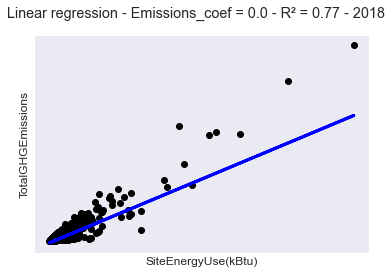




2017
Number of points: 2588 dont train: 1800
Coefficients: 
 [[2.17877551e-05]]
Mean square error: 6753.00
Determination coefficient: 0.78
Emissions coef save: 2.1787755062522604e-05
WN Coefficient: 0.000


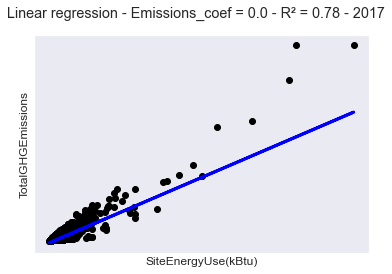




2016
Number of points: 2588 dont train: 1800
Coefficients: 
 [[2.71873738e-05]]
Mean square error: 9385.24
Determination coefficient: 0.82
Emissions coef save: 2.7187373807551782e-05
WN Coefficient: 0.000


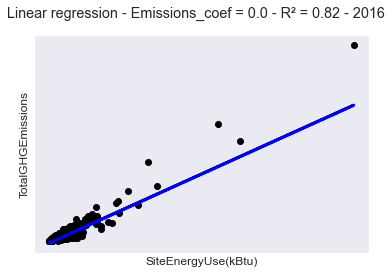




2015
Number of points: 2588 dont train: 1800
Coefficients: 
 [[2.68105687e-05]]
Mean square error: 8115.99
Determination coefficient: 0.75
Emissions coef save: 2.681056871896028e-05
WN Coefficient: 0.000


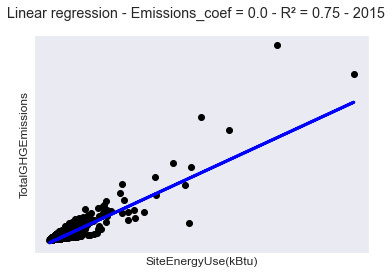




2019
Number of points: 2588 dont train: 1800
Coefficients: 
 [[2.37433452e-05]]
Mean square error: 7005.69
Determination coefficient: 0.78
Emissions coef save: 2.3743345167182847e-05
WN Coefficient: 0.000


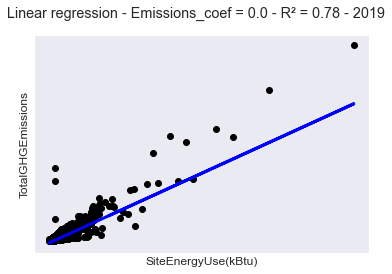




2020
Number of points: 2518 dont train: 1800
Coefficients: 
 [[2.78821813e-05]]
Mean square error: 9399.22
Determination coefficient: 0.73
Emissions coef save: 2.788218129686507e-05
WN Coefficient: 0.000


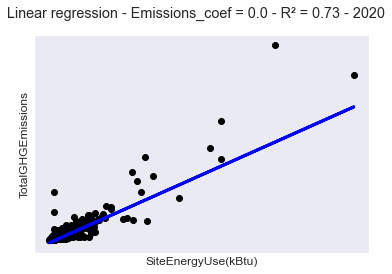

In [ ]:
# years: year_minus_1,year_minus_2,year_minus_3,year_minus_4,year,year_plus_1:

Emissions_coef = {}

for data_year in [year_minus_1,year_minus_2,year_minus_3,year_minus_4,year,year_plus_1]:
    
    # Creation of a dataframe filtered on the year
    df = data_fix_set[data_year].copy()
    df_year = df[df['DataYear'] == int(data_year)]
    
    # Transformation from log to exp:
    df_year['SiteEnergyUse(kBtu)_bis'] = df_year['SiteEnergyUse(kBtu)'].apply(lambda x: np.power(10,x))
    df_year['TotalGHGEmissions_bis'] = df_year['TotalGHGEmissions'].apply(lambda x: np.power(10,x))
    
    # Train/test split of the input
    energy_X_train = df_year['SiteEnergyUse(kBtu)_bis'][:-1800].values.reshape(-1, 1)
    energy_X_test = df_year['SiteEnergyUse(kBtu)_bis'][-1800:].values.reshape(-1, 1)

    # Train/test split of the target
    emissions_y_train = df_year['TotalGHGEmissions_bis'][:-1800].values.reshape(-1, 1)
    emissions_y_test = df_year['TotalGHGEmissions_bis'][-1800:].values.reshape(-1, 1)

    # Model instance
    regr_GHG = linear_model.LinearRegression()

    # Model fitting
    regr_GHG.fit(energy_X_train, emissions_y_train)

    # Prediction
    emissions_y_pred = regr_GHG.predict(energy_X_test)
        
    # Year print
    print("\n\n")
    print(int(data_year))
    
    # Number of points:
    print(f"Number of points: {df_year.shape[0]} dont train: 1800")
    
    # Model coefficients
    print('Coefficients: \n', regr_GHG.coef_)
    
    # MSE
    MSE = mean_squared_error(emissions_y_test, emissions_y_pred)
    print('Mean square error: %.2f'
          % MSE)
    
    # R²
    R2 = r2_score(emissions_y_test, emissions_y_pred)
    print('Determination coefficient: %.2f'
          % R2)
    
    # WN coeff saving
    Emissions_coef_save = regr_GHG.coef_[0][0]
    Emissions_coef[data_year] = round(Emissions_coef_save, 3)
    print(f"Emissions coef save: {Emissions_coef_save}")
    
    # Printing
    print('WN Coefficient: %.3f'
          % Emissions_coef[data_year]) 
    
    # Output plot 
    plt.scatter(energy_X_test, emissions_y_test,  color='black')
    plt.plot(energy_X_test, emissions_y_pred, color='blue', linewidth=3)

    plt.xlabel('SiteEnergyUse(kBtu)')
    plt.ylabel('TotalGHGEmissions')
    plt.suptitle(f"Linear regression - Emissions_coef = {Emissions_coef[data_year]} - R² = {round(R2,2)} - {int(data_year)}")

    plt.xticks(())
    plt.yticks(())
        
    
    # Save
    file = int(data_year)
    plt.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{file}\\regression_energy_emissions_{file}.png", transparent=True)
    
    # Show
    plt.show()


In [ ]:
Emissions_coef

{'2018': 0.0, '2017': 0.0, '2016': 0.0, '2015': 0.0, '2019': 0.0, '2020': 0.0}

# GHG EMISSION CALCULATION - {year}

### Rebuilding od 'SiteEnergyUse(kBtu)' with the parts a + b

In [ ]:
# The target 'SiteEnergyUse(kBtu)' must be reconstructed gathering data_fix_set and data_fix_set_test[year] (a et b)
energy_target_year_predicted_df.shape[0]

2899

In [ ]:
data_fix_set[year].shape[0] + data_fix_set_test[year].shape[0]

2899

In [ ]:
# Creation of a dataframe with the target - part a
energy_target_year_a = pd.DataFrame(data_fix_set[year]['SiteEnergyUse(kBtu)'], columns=['SiteEnergyUse(kBtu)'])
energy_target_year_a

,SiteEnergyUse(kBtu)
0,6.867068
1,6.905291
2,7.834774
4,7.200717
6,6.752323
...,...
3055,6.439646
3060,5.558820
3068,6.062291
3072,6.149007


In [ ]:
# Creation of a dataframe with the target - part b
energy_target_year_b = pd.DataFrame(data_fix_set_test[year]['SiteEnergyUse(kBtu)'], columns=['SiteEnergyUse(kBtu)'])
energy_target_year_b

,SiteEnergyUse(kBtu)
3,6.802557
22,6.227567
30,6.181802
34,8.743981
36,6.890544
...,...
3165,6.893441
3166,7.465696
3169,6.084487
3172,5.974567


In [ ]:
# Concatenation
energy_target_year = pd.concat([energy_target_year_a, energy_target_year_b])

In [ ]:
# Reseting index
energy_target_year.reset_index(drop=True, inplace=True)

In [ ]:
energy_target_year

,SiteEnergyUse(kBtu)
0,6.867068
1,6.905291
2,7.834774
3,7.200717
4,6.752323
...,...
2894,6.893441
2895,7.465696
2896,6.084487
2897,5.974567


### Rebuilding of 'TotalGHGEmissions' with the part a + b

In [ ]:
# Creation of a dataframe with the target - part a
emissions_target_year_a = pd.DataFrame(data_fix_set[year]['TotalGHGEmissions'], columns=['TotalGHGEmissions'])
emissions_target_year_a

,TotalGHGEmissions
0,2.319730
1,2.457731
2,3.190051
4,2.769008
6,2.281715
...,...
3055,1.789581
3060,0.342423
3068,0.845098
3072,1.390935


In [ ]:
# Creation of a dataframe with the target - part b
emissions_target_year_b = pd.DataFrame(data_fix_set_test[year]['TotalGHGEmissions'], columns=['TotalGHGEmissions'])
emissions_target_year_b

,TotalGHGEmissions
3,2.366236
22,1.692847
30,0.963788
34,4.334482
36,2.515609
...,...
3165,2.304706
3166,2.810434
3169,1.530200
3172,1.352183


In [ ]:
# Concatenation
emissions_target_year = pd.concat([emissions_target_year_a, emissions_target_year_b])

In [ ]:
# Resetting index
emissions_target_year.reset_index(drop=True, inplace=True)

In [ ]:
emissions_target_year

,TotalGHGEmissions
0,2.319730
1,2.457731
2,3.190051
3,2.769008
4,2.281715
...,...
2894,2.304706
2895,2.810434
2896,1.530200
2897,1.352183


### Check of the correlation between the predicted energy and the GHG emissions

In [ ]:
energy_target_year_predicted_df

,SiteEnergyUse(kBtu)_predicted_2019
0,6.366729
1,6.542415
2,7.584474
3,6.750004
4,6.366729
...,...
2894,7.096162
2895,7.584474
2896,6.366729
2897,6.057612


In [ ]:
# Creation of a datafrmae with the two energy variables (real and predicted) + GHG emissions:
year_d_frame = energy_target_year.copy()
year_d_frame[f'SiteEnergyUse(kBtu)_predicted_{year}'] = energy_target_year_predicted_df[f'SiteEnergyUse(kBtu)_predicted_{year}']
year_d_frame['TotalGHGEmissions'] = emissions_target_year['TotalGHGEmissions']
year_d_frame

,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)_predicted_2019,TotalGHGEmissions
0,6.867068,6.366729,2.319730
1,6.905291,6.542415,2.457731
2,7.834774,7.584474,3.190051
3,7.200717,6.750004,2.769008
4,6.752323,6.366729,2.281715
...,...,...,...
2894,6.893441,7.096162,2.304706
2895,7.465696,7.584474,2.810434
2896,6.084487,6.366729,1.530200
2897,5.974567,6.057612,1.352183


#### Pearson coefficient

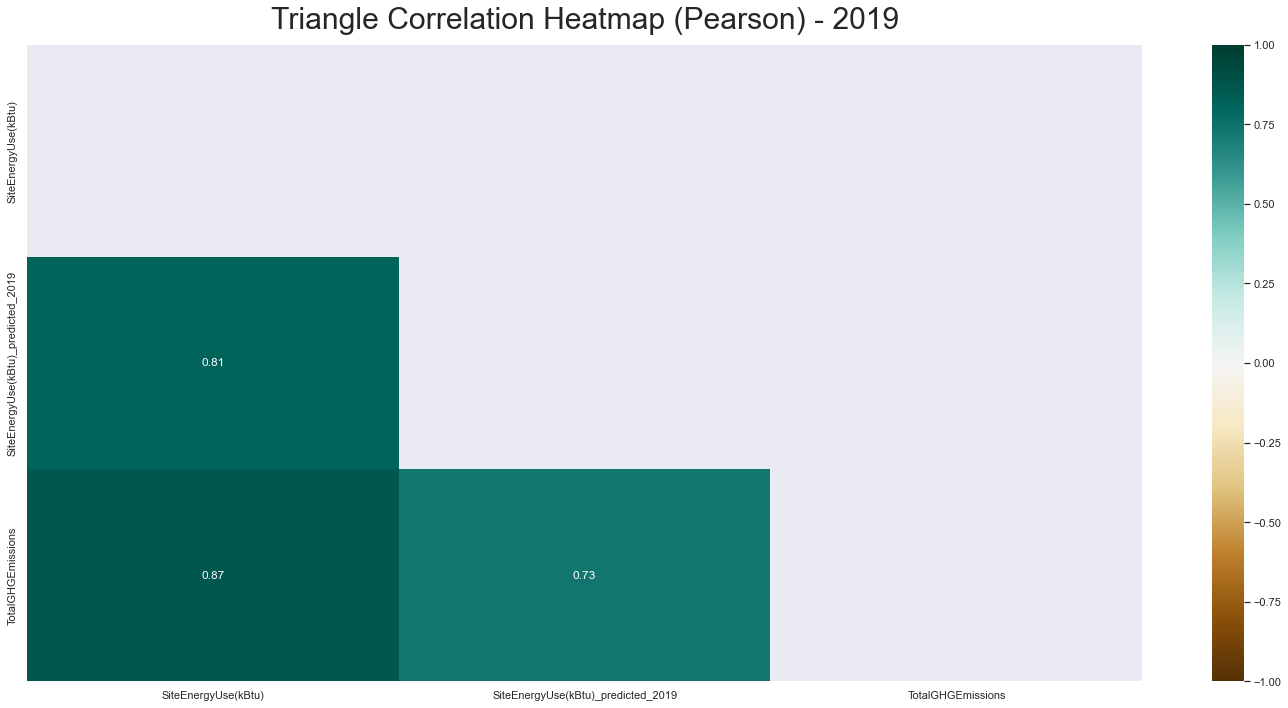

In [ ]:
# Heatmap 
plt.figure(figsize=(20, 10))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(year_d_frame.corr()))
heatmap = sns.heatmap(year_d_frame.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title(f'Triangle Correlation Heatmap (Pearson) - {year}', fontdict={'fontsize':30}, pad=16);
plt.tight_layout()

# Figure
fig = heatmap.get_figure()

# Save
data_year = year
file = int(data_year)
plt.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{file}\\regression_energy_prédite_emissions_{file}.png", transparent=True)

# Show()
plt.show()



We can see the evolution of the Pearson coefficient




2019
Nombre de points: 2899 dont train: 1800
Coefficients: 
 [[1.09456486]]
Erreur quadratique moyenne: 0.21
Coefficient of determination: 0.50
Emissions coef save: 1.0945648627209874
Coefficient Emissions: 1.095


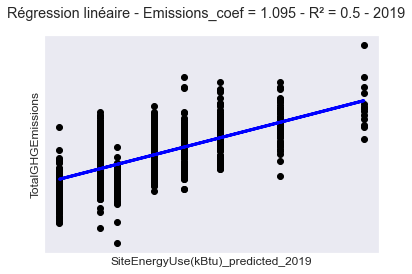

In [ ]:
# year

Emissions_coef = {}

for data_year in [year]:
    
    # Creation of a dataframe filtered on the year
    df_year = year_d_frame.copy()
    
    # Train/test split of the input
    energy_X_train = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][:-1800].values.reshape(-1, 1)
    energy_X_test = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][-1800:].values.reshape(-1, 1)

    # Train/test split of the target
    emissions_y_train = df_year['TotalGHGEmissions'][:-1800].values.reshape(-1, 1)
    emissions_y_test = df_year['TotalGHGEmissions'][-1800:].values.reshape(-1, 1)

    # Model instance
    regr_GHG = linear_model.LinearRegression()

    # Model fitting
    regr_GHG.fit(energy_X_train, emissions_y_train)

    # Prediction
    emissions_y_pred = regr_GHG.predict(energy_X_test)
        
    # Year print
    print("\n\n")
    print(int(data_year))
    
    # Number of points:
    print(f"Nombre de points: {df_year.shape[0]} dont train: 1800")
    
    # Model coefficients
    print('Coefficients: \n', regr_GHG.coef_)
    
    # MSE
    MSE = mean_squared_error(emissions_y_test, emissions_y_pred)
    print('Erreur quadratique moyenne: %.2f'
          % MSE)
    
    # R²
    R2 = r2_score(emissions_y_test, emissions_y_pred)
    print('Coefficient of determination: %.2f'
          % R2)

    # WN coeff saving
    Emissions_coef_save = regr_GHG.coef_[0][0]
    Emissions_coef[data_year] = round(Emissions_coef_save, 3)
    print(f"Emissions coef save: {Emissions_coef_save}")

    # Printing
    print('Coefficient Emissions: %.3f'
          % Emissions_coef[data_year]) 
    
    # Output plot 
    plt.scatter(energy_X_test, emissions_y_test,  color='black')
    plt.plot(energy_X_test, emissions_y_pred, color='blue', linewidth=3)

    plt.xlabel(f'SiteEnergyUse(kBtu)_predicted_{year}')
    plt.ylabel('TotalGHGEmissions')
    plt.suptitle(f"Régression linéaire - Emissions_coef = {Emissions_coef[data_year]} - R² = {round(R2,2)} - {int(data_year)}")

    plt.xticks(())
    plt.yticks(())
        
    
    # Save
    file = int(data_year)
    plt.savefig(f"projets\\04_seattle_building_energy\\production\\savefig\\{file}\\regression_energyWN_energy_{file}.png", transparent=True)
    
    # Show
    plt.show()


### Rebuilding of 'energy_type_01' with parts a + b

In [ ]:
# Creation of a dataframe with the target - part a
type_energy_year_a = pd.DataFrame(data_fix_set[year]['energy_type_01'], columns=['energy_type_01'])
type_energy_year_a

,energy_type_01
0,electricity
1,gas
2,electricity
4,gas
6,gas
...,...
3055,electricity
3060,electricity
3068,electricity
3072,electricity


In [ ]:
# Creation of a dataframe with the target - part b
type_energy_year_b = pd.DataFrame(data_fix_set_test[year]['energy_type_01'], columns=['energy_type_01'])
type_energy_year_b

,energy_type_01
3,electricity
22,gas
30,electricity
34,gas
36,gas
...,...
3165,electricity
3166,electricity
3169,electricity
3172,electricity


In [ ]:
# Concatenation
type_energy_year = pd.concat([type_energy_year_a, type_energy_year_b])

In [ ]:
# Resetting
type_energy_year.reset_index(drop=True, inplace=True)

In [ ]:
type_energy_year

,energy_type_01
0,electricity
1,gas
2,electricity
3,gas
4,gas
...,...
2894,electricity
2895,electricity
2896,electricity
2897,electricity


In [ ]:
# Variable adding
year_d_frame['energy_type_01'] = type_energy_year['energy_type_01']
year_d_frame['energy_type_01'] = type_energy_year['energy_type_01']
year_d_frame

,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)_predicted_2019,TotalGHGEmissions,energy_type_01
0,6.867068,6.366729,2.319730,electricity
1,6.905291,6.542415,2.457731,gas
2,7.834774,7.584474,3.190051,electricity
3,7.200717,6.750004,2.769008,gas
4,6.752323,6.366729,2.281715,gas
...,...,...,...,...
2894,6.893441,7.096162,2.304706,electricity
2895,7.465696,7.584474,2.810434,electricity
2896,6.084487,6.366729,1.530200,electricity
2897,5.974567,6.057612,1.352183,electricity


In [ ]:
# Filter of the datafrmae depending on the type of energy: 'electricity'
electricity_year_d_frame = year_d_frame[year_d_frame['energy_type_01'] == 'electricity']
electricity_year_d_frame

,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)_predicted_2019,TotalGHGEmissions,energy_type_01
0,6.867068,6.366729,2.319730,electricity
2,7.834774,7.584474,3.190051,electricity
5,6.866463,6.542415,2.280806,electricity
7,6.706596,6.366729,2.186391,electricity
8,7.280355,6.750004,2.767007,electricity
...,...,...,...,...
2894,6.893441,7.096162,2.304706,electricity
2895,7.465696,7.584474,2.810434,electricity
2896,6.084487,6.366729,1.530200,electricity
2897,5.974567,6.057612,1.352183,electricity


In [ ]:
# Filter of the datafrmae depending on the type of energy: 'gas'
gas_year_d_frame = year_d_frame[year_d_frame['energy_type_01'] == 'gas']
gas_year_d_frame

,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)_predicted_2019,TotalGHGEmissions,energy_type_01
1,6.905291,6.542415,2.457731,gas
3,7.200717,6.750004,2.769008,gas
4,6.752323,6.366729,2.281715,gas
6,7.160454,6.750004,2.667920,gas
10,6.640720,6.366729,2.235528,gas
...,...,...,...,...
2850,6.361711,6.057612,1.924796,gas
2852,7.244905,7.096162,2.728273,gas
2859,6.867218,6.750004,2.351989,gas
2883,6.682990,6.750004,2.169380,gas


In [ ]:
# Filter of the datafrmae depending on the type of energy: 'steam'
steam_year_d_frame = year_d_frame[year_d_frame['energy_type_01'] == 'steam']
steam_year_d_frame

,SiteEnergyUse(kBtu),SiteEnergyUse(kBtu)_predicted_2019,TotalGHGEmissions,energy_type_01
12,6.920499,6.366729,2.488833,steam
14,7.079346,6.542415,2.582858,steam
55,7.140421,7.096162,2.628491,steam
116,8.351410,7.584474,3.848515,steam
123,6.697197,6.542415,2.170555,steam
139,6.525719,6.366729,2.082067,steam
142,7.253555,7.096162,2.751356,steam
145,5.812184,6.366729,1.413300,steam
185,7.699901,7.584474,3.235099,steam
195,7.517639,7.096162,3.063071,steam


#### Correlation between GHG Emissions/Energy per energy type

##### 'electricity'

In [ ]:
electricity_year_d_frame.shape

(2231, 4)




2019
Number of points: 2231 dont train: 1500
Coefficients: 
 [[1.10905116]]
Mean square error: 0.14
Determination coefficient: 0.61
Emissions coef save: 1.1090511639239813
WN Coefficient: 1.109


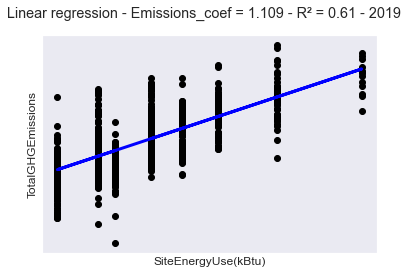

In [ ]:
# year - 'electricity'

Emissions_coef = {}

for data_year in [year]:
    
    # Creation of a dataframe filtered on the year
    df_year = electricity_year_d_frame.copy()
    
    # Train/test split of the input
    energy_X_train = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][:-1500].values.reshape(-1, 1)
    energy_X_test = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][-1500:].values.reshape(-1, 1)

    # Train/test split of the target
    emissions_y_train = df_year['TotalGHGEmissions'][:-1500].values.reshape(-1, 1)
    emissions_y_test = df_year['TotalGHGEmissions'][-1500:].values.reshape(-1, 1)

    # Model instance
    regr_GHG = linear_model.LinearRegression()

    # Model fitting
    regr_GHG.fit(energy_X_train, emissions_y_train)

    # Prediction
    emissions_y_pred = regr_GHG.predict(energy_X_test)
        
    # Year print
    print("\n\n")
    print(int(data_year))
    
    # Number of points:
    print(f"Number of points: {df_year.shape[0]} dont train: 1500")
    
    # Model coefficients
    print('Coefficients: \n', regr_GHG.coef_)
    
    # MSE
    MSE = mean_squared_error(emissions_y_test, emissions_y_pred)
    print('Mean square error: %.2f'
          % MSE)
    
    # R²
    R2 = r2_score(emissions_y_test, emissions_y_pred)
    print('Determination coefficient: %.2f'
          % R2)
    
    # WN coeff saving
    Emissions_coef_save = regr_GHG.coef_[0][0]
    Emissions_coef[data_year] = round(Emissions_coef_save, 3)
    print(f"Emissions coef save: {Emissions_coef_save}")

    # Printing
    print('WN Coefficient: %.3f'
          % Emissions_coef[data_year]) 
    
    # Output plot 
    plt.scatter(energy_X_test, emissions_y_test,  color='black')
    plt.plot(energy_X_test, emissions_y_pred, color='blue', linewidth=3)

    plt.xlabel('SiteEnergyUse(kBtu)')
    plt.ylabel('TotalGHGEmissions')
    plt.suptitle(f"Linear regression - Emissions_coef = {Emissions_coef[data_year]} - R² = {round(R2,2)} - {int(data_year)}")

    plt.xticks(())
    plt.yticks(())
        
    
    # Save
    file = int(data_year)
    
    # Show
    plt.show()


##### 'gas'

In [ ]:
gas_year_d_frame.shape

(632, 4)




2019
Number of points: 632 dont train: 400
Coefficients: 
 [[1.073571]]
Mean square error: 0.08
Determination coefficient: 0.49
Emissions coef save: 1.0735709961138045
WN Coefficient: 1.074


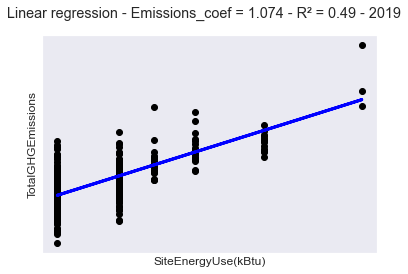

In [ ]:
# year - 'gas'

Emissions_coef = {}

for data_year in [year]:
    
    # Creation of a dataframe filtered on the year
    df_year = gas_year_d_frame.copy()
    
    # Train/test split of the input
    energy_X_train = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][:-400].values.reshape(-1, 1)
    energy_X_test = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][-400:].values.reshape(-1, 1)

    # Train/test split of the target
    emissions_y_train = df_year['TotalGHGEmissions'][:-400].values.reshape(-1, 1)
    emissions_y_test = df_year['TotalGHGEmissions'][-400:].values.reshape(-1, 1)

    # Model instance
    regr_GHG = linear_model.LinearRegression()

    # Model fitting
    regr_GHG.fit(energy_X_train, emissions_y_train)

    # Prediction
    emissions_y_pred = regr_GHG.predict(energy_X_test)
        
    # Year print
    print("\n\n")
    print(int(data_year))
    
    # Number of points:
    print(f"Number of points: {df_year.shape[0]} dont train: 400")
    
    # Model coefficients
    print('Coefficients: \n', regr_GHG.coef_)
    
    # MSE
    MSE = mean_squared_error(emissions_y_test, emissions_y_pred)
    print('Mean square error: %.2f'
          % MSE)
    
    # R²
    R2 = r2_score(emissions_y_test, emissions_y_pred)
    print('Determination coefficient: %.2f'
          % R2)

    # WN coeff saving
    Emissions_coef_save = regr_GHG.coef_[0][0]
    Emissions_coef[data_year] = round(Emissions_coef_save, 3)
    print(f"Emissions coef save: {Emissions_coef_save}")

    # Printing
    print('WN Coefficient: %.3f'
          % Emissions_coef[data_year]) 
    
    # Output plot 
    plt.scatter(energy_X_test, emissions_y_test,  color='black')
    plt.plot(energy_X_test, emissions_y_pred, color='blue', linewidth=3)

    plt.xlabel('SiteEnergyUse(kBtu)')
    plt.ylabel('TotalGHGEmissions')
    plt.suptitle(f"Linear regression - Emissions_coef = {Emissions_coef[data_year]} - R² = {round(R2,2)} - {int(data_year)}")

    plt.xticks(())
    plt.yticks(())
        
    
    # Save
    file = int(data_year)
    
    # Show
    plt.show()


##### 'steam'

In [ ]:
steam_year_d_frame.shape

(36, 4)




2019
Nombre de points: 36 dont train: 20
Coefficients: 
 [[1.06777604]]
Erreur quadratique moyenne: 0.28
Coefficient of determination: 0.17
Emissions coef save: 1.0677760426850347
Coefficient Emissions: 1.068


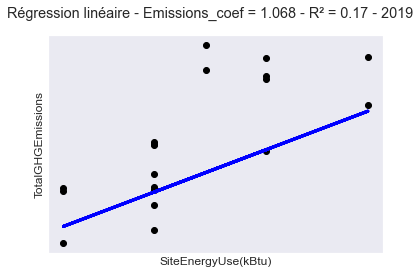

In [ ]:
# year - 'steam'

Emissions_coef = {}

for data_year in [year]:
    
    # Creation of a dataframe filtered on the year
    df_year = steam_year_d_frame.copy()
    
    # Train/test split of the input
    energy_X_train = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][:-20].values.reshape(-1, 1)
    energy_X_test = df_year[f'SiteEnergyUse(kBtu)_predicted_{year}'][-20:].values.reshape(-1, 1)

    # Train/test split of the target
    emissions_y_train = df_year['TotalGHGEmissions'][:-20].values.reshape(-1, 1)
    emissions_y_test = df_year['TotalGHGEmissions'][-20:].values.reshape(-1, 1)

    # Model instance
    regr_GHG = linear_model.LinearRegression()

    # Model fitting
    regr_GHG.fit(energy_X_train, emissions_y_train)

    # Prediction
    emissions_y_pred = regr_GHG.predict(energy_X_test)
        
    # Year print
    print("\n\n")
    print(int(data_year))
    
    # Number of points:
    print(f"Nombre de points: {df_year.shape[0]} dont train: 20")
    
    # Model coefficients
    print('Coefficients: \n', regr_GHG.coef_)
    
    # MSE
    MSE = mean_squared_error(emissions_y_test, emissions_y_pred)
    print('Erreur quadratique moyenne: %.2f'
          % MSE)
    
    # R²
    R2 = r2_score(emissions_y_test, emissions_y_pred)
    print('Coefficient of determination: %.2f'
          % R2)

    # WN coeff saving
    Emissions_coef_save = regr_GHG.coef_[0][0]
    Emissions_coef[data_year] = round(Emissions_coef_save, 3)
    print(f"Emissions coef save: {Emissions_coef_save}")

    # Printing
    print('Coefficient Emissions: %.3f'
          % Emissions_coef[data_year]) 
    
    # Output plot
    plt.scatter(energy_X_test, emissions_y_test,  color='black')
    plt.plot(energy_X_test, emissions_y_pred, color='blue', linewidth=3)

    plt.xlabel('SiteEnergyUse(kBtu)')
    plt.ylabel('TotalGHGEmissions')
    plt.suptitle(f"Régression linéaire - Emissions_coef = {Emissions_coef[data_year]} - R² = {round(R2,2)} - {int(data_year)}")

    plt.xticks(())
    plt.yticks(())
        
    
    # Save
    file = int(data_year)

    # Show
    plt.show()


The determination coefficient is too low, the GHG emissions cannot be predicted from the predicted energy. The same method as the energy prediction has to be done again 

# MODIFIED DATASET EXPORT - CSV

In [ ]:
fix_set_year = int(year) - 1

In [ ]:
# data_fix_set_train_val

# Saving to csv 

returnValue = data_fix_set_train_val.to_csv(f'projets\\04_seattle_building_energy\\production\\ML\\seattle_building_data_fix_set_{fix_set_year}freeze_train_val.csv',sep = ',', index=False)
print(returnValue)

None


In [ ]:
# data_fix_set_train_val_random

# Saving to csv 

returnValue = data_fix_set_train_val_random.to_csv(f'projets\\04_seattle_building_energy\\production\\ML\\seattle_building_data_fix_set_{fix_set_year}freeze_train_val_random.csv',sep = ',', index=False)
print(returnValue)

None


In [ ]:
# data_fix_set

# Saving to csv 
for data_year in [year_minus_4,year_minus_3, year_minus_2, year_minus_1, year, year_plus_1]:
    value = str(data_year)
    returnValue = data_fix_set[str(data_year)].to_csv(f'projets\\04_seattle_building_energy\\production\\ML\\seattle_building_data_fix_set_{fix_set_year}freeze_{value}.csv',sep = ',', index=False)


In [ ]:
# data_fix_set_test

# Saving to csv 
for data_year in [year, year_plus_1]:
    value = str(data_year)
    returnValue = data_fix_set_test[str(data_year)].to_csv(f'projets\\04_seattle_building_energy\\production\\ML\\seattle_building_data_fix_set_{fix_set_year}freeze_test_{value}_nouveaux.csv',sep = ',', index=False)
    print(returnValue)

None
None
